In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
import wfdb
import os

In [91]:
# Data Loading 
def load_ecg_data(folder_path):
   
    all_signals = []
    all_annotations = []
    all_headers = []
    file_names = []


    for file in os.listdir(folder_path):
        if file.endswith('.hea'):
            record_name = os.path.splitext(file)[0]
            record_path = os.path.join(folder_path, record_name)
            
            
            if not os.path.exists(f"{record_path}.dat"):
                print(f"Data file not found for {record_name}. Skipping...")
                continue
            
            try:
                
                record = wfdb.rdrecord(record_path)
                signal = record.p_signal.flatten() if record.p_signal.ndim > 1 else record.p_signal
                
                
                try:
                    ann = wfdb.rdann(record_path, 'pwave')
                    annotations = ann.sample
                except:
                    print(f"No P-wave annotations found for {record_name}")
                    annotations = []
                
                # Store the data
                all_signals.append(signal)
                all_annotations.append(annotations)
                all_headers.append(record)
                file_names.append(record_name)

            except Exception as e:
                print(f"Error loading {record_name}: {str(e)}")
                continue

    return all_signals, all_annotations, all_headers, file_names

# Load the data
folder_path = r'C:\Users\jalad\Downloads\mit-bih-arrhythmia-database-p-wave-annotations-1.0.0 (1)\mit-bih-arrhythmia-database-p-wave-annotations-1.0.0'
signals, annotations, headers, file_names = load_ecg_data(folder_path)


print(f"Loaded {len(signals)} ECG records")
for i, name in enumerate(file_names):
    print(f"Record {i + 1}: {name}, Length: {len(signals[i])}, Annotations: {len(annotations[i])}")


Loaded 12 ECG records
Record 1: 100, Length: 1300000, Annotations: 2257
Record 2: 101, Length: 1300000, Annotations: 1865
Record 3: 103, Length: 1300000, Annotations: 2084
Record 4: 106, Length: 1300000, Annotations: 1507
Record 5: 117, Length: 1300000, Annotations: 1534
Record 6: 119, Length: 1300000, Annotations: 1620
Record 7: 122, Length: 1300000, Annotations: 2475
Record 8: 207, Length: 1300000, Annotations: 1415
Record 9: 214, Length: 1300000, Annotations: 2001
Record 10: 222, Length: 1300000, Annotations: 1257
Record 11: 223, Length: 1300000, Annotations: 2099
Record 12: 231, Length: 1300000, Annotations: 1994


In [92]:
# Preprocessing Functions
from scipy.signal import butter, filtfilt, find_peaks

def filter_signal(signal, fs=360, lowcut=0.5, highcut=50):
    
    nyq = 0.5 * fs  
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(2, [low, high], btype='band')  
    filtered_signal = filtfilt(b, a, signal)  
    return filtered_signal

def scale_signal(signal):
    
    return (signal - np.mean(signal)) / np.std(signal)

def detect_peaks_and_valleys(signal, distance=150):
    
    peaks, _ = find_peaks(signal, distance=distance)
    valleys, _ = find_peaks(-signal, distance=distance)  
    return peaks, valleys

def preprocess_all_signals(signals):
    
    processed_results = []
    for signal in signals:
        filtered_signal = filter_signal(signal)
        scaled_signal = scale_signal(filtered_signal)
        peaks, valleys = detect_peaks_and_valleys(scaled_signal)
        
        processed_results.append({
            'original': signal,
            'filtered': filtered_signal,
            'scaled': scaled_signal,
            'peaks': peaks,
            'valleys': valleys
        })
    return processed_results


processed_signals = preprocess_all_signals(signals)


for i, result in enumerate(processed_signals):
    print(f"Record {file_names[i]}:")
    print(f"  Original Signal Length: {len(result['original'])}")
    print(f"  Filtered Signal Length: {len(result['filtered'])}")
    print(f"  Scaled Signal Length: {len(result['scaled'])}")
    print(f"  Number of Peaks Detected: {len(result['peaks'])}")
    print(f"  Number of Valleys Detected: {len(result['valleys'])}")
    print()


Record 100:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal Length: 1300000
  Number of Peaks Detected: 6168
  Number of Valleys Detected: 6771

Record 101:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal Length: 1300000
  Number of Peaks Detected: 6136
  Number of Valleys Detected: 6928

Record 103:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal Length: 1300000
  Number of Peaks Detected: 6386
  Number of Valleys Detected: 6253

Record 106:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal Length: 1300000
  Number of Peaks Detected: 6733
  Number of Valleys Detected: 6264

Record 117:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal Length: 1300000
  Number of Peaks Detected: 6110
  Number of Valleys Detected: 6091

Record 119:
  Original Signal Length: 1300000
  Filtered Signal Length: 1300000
  Scaled Signal

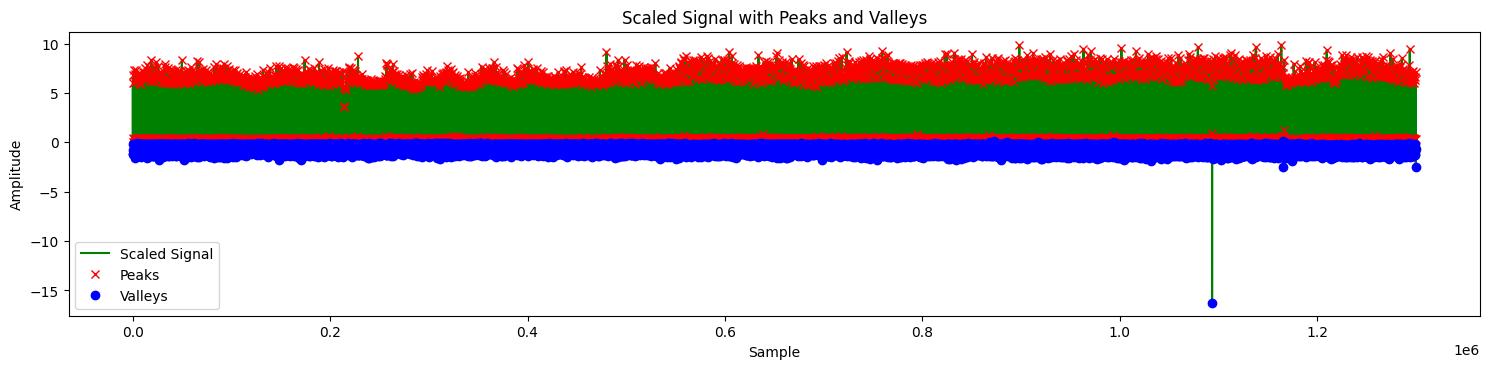

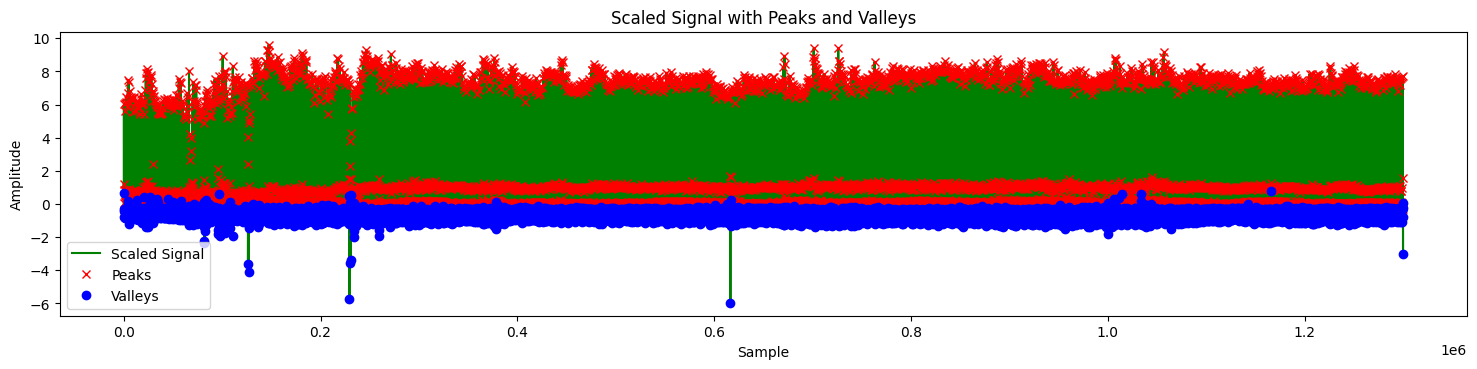

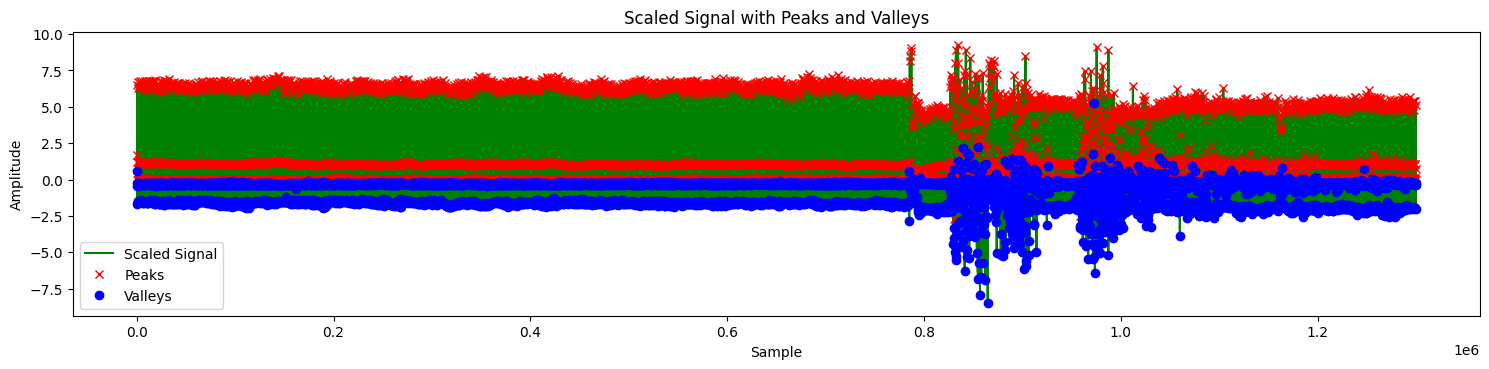

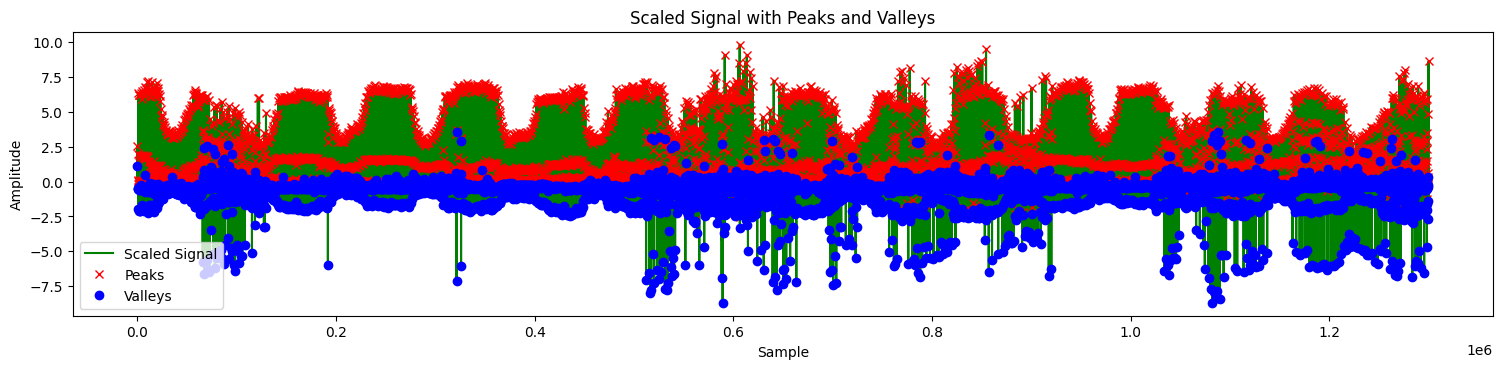

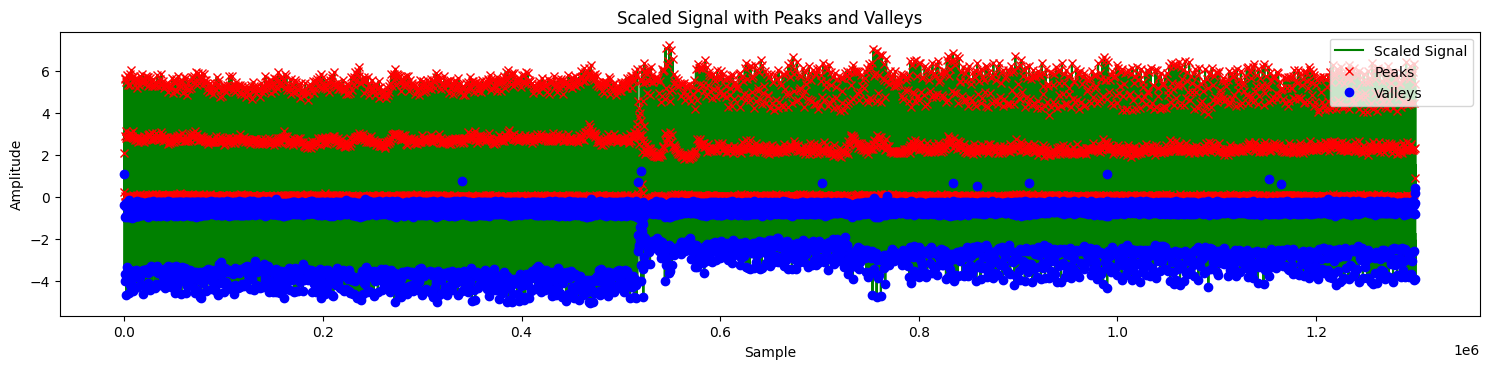

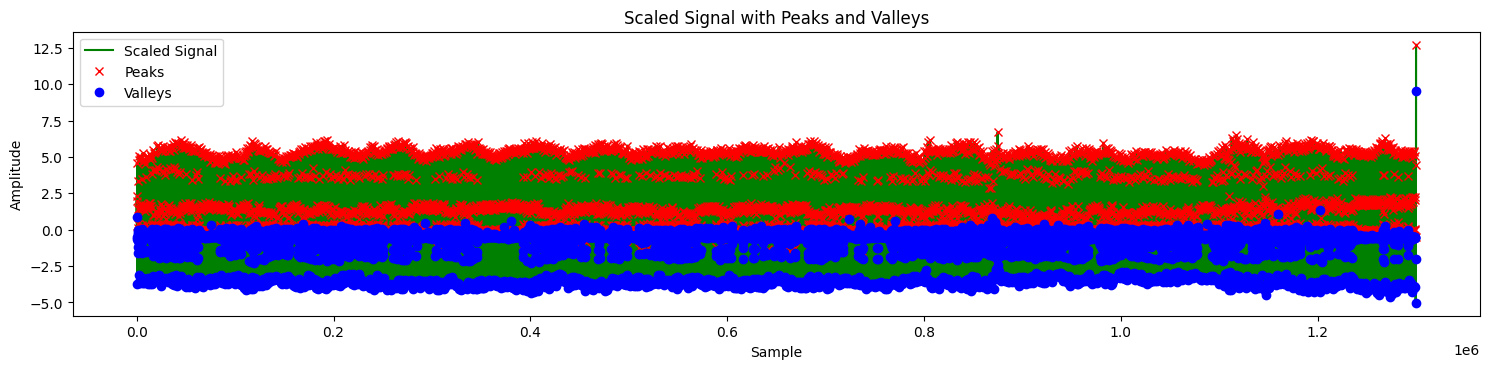

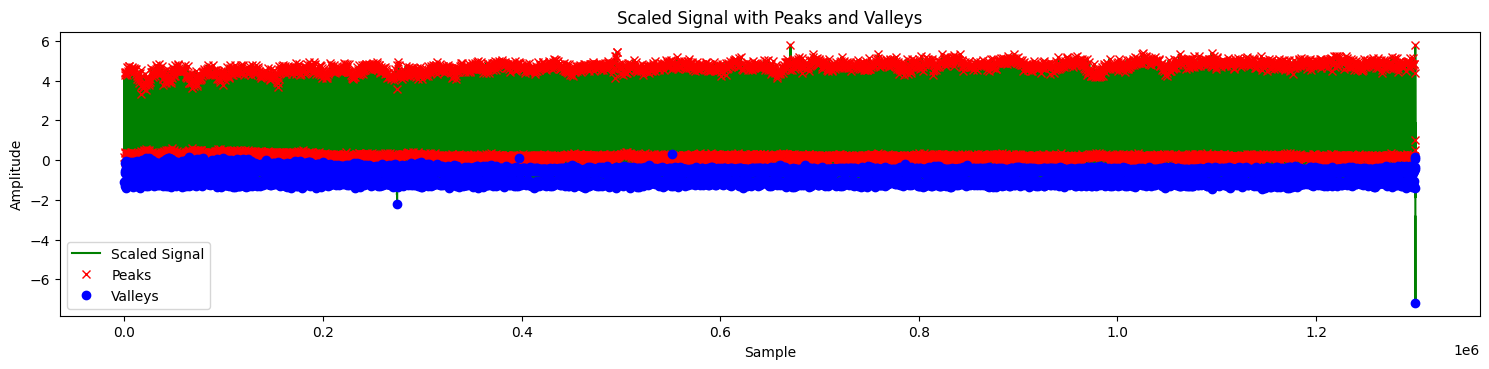

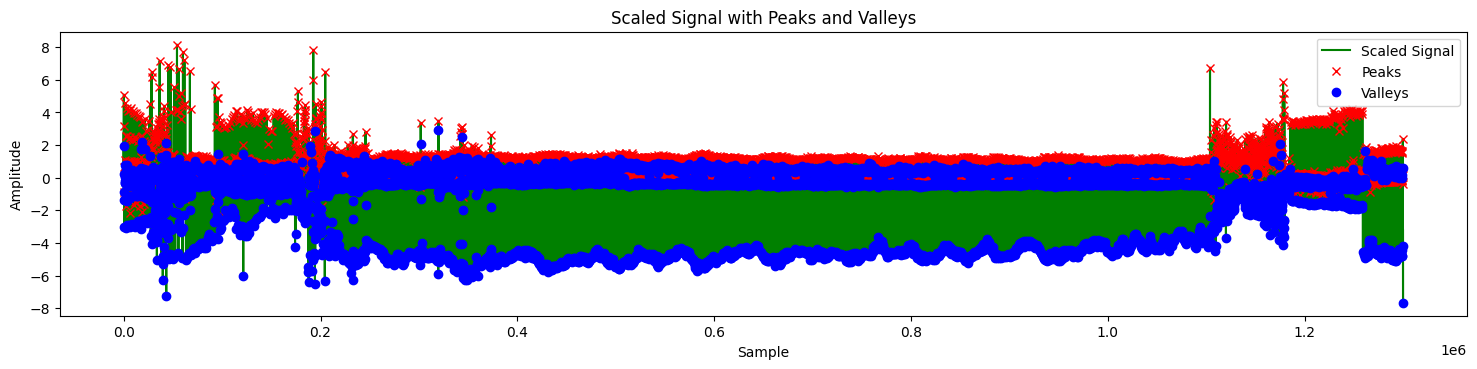

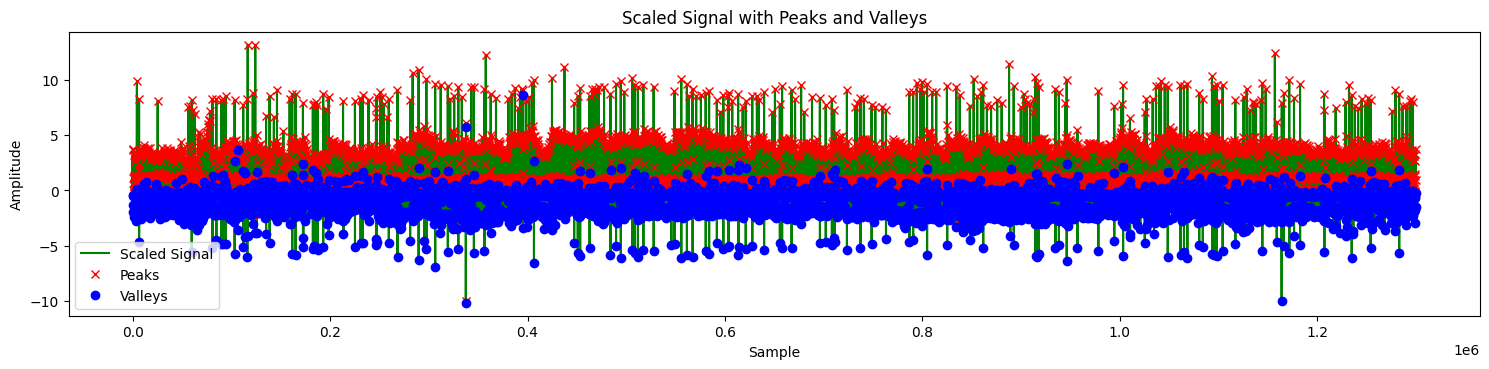

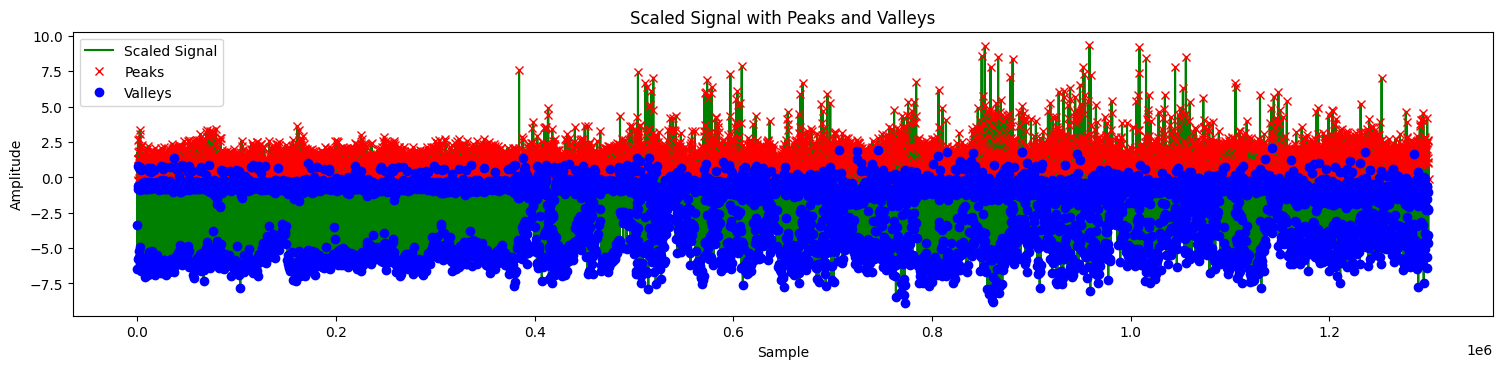

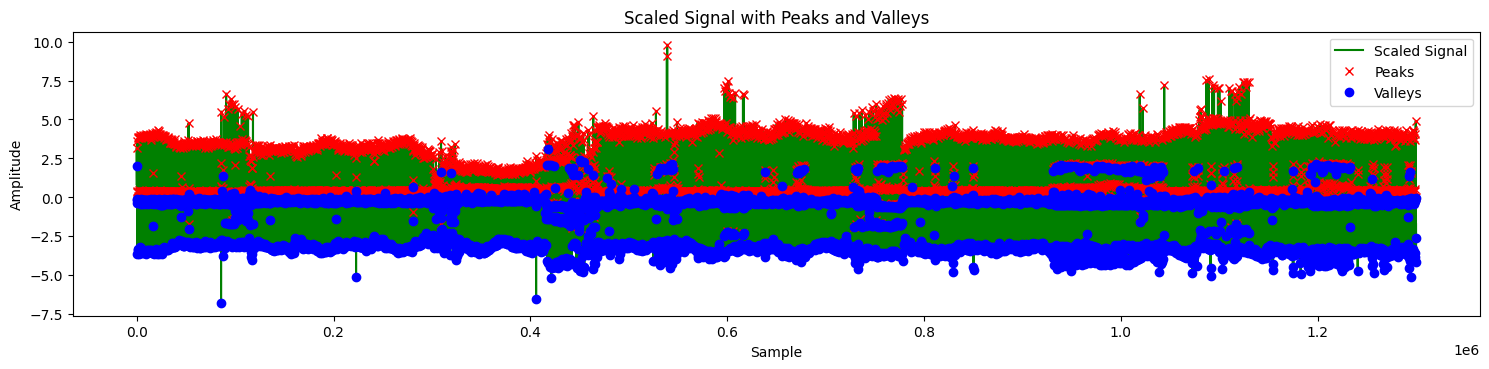

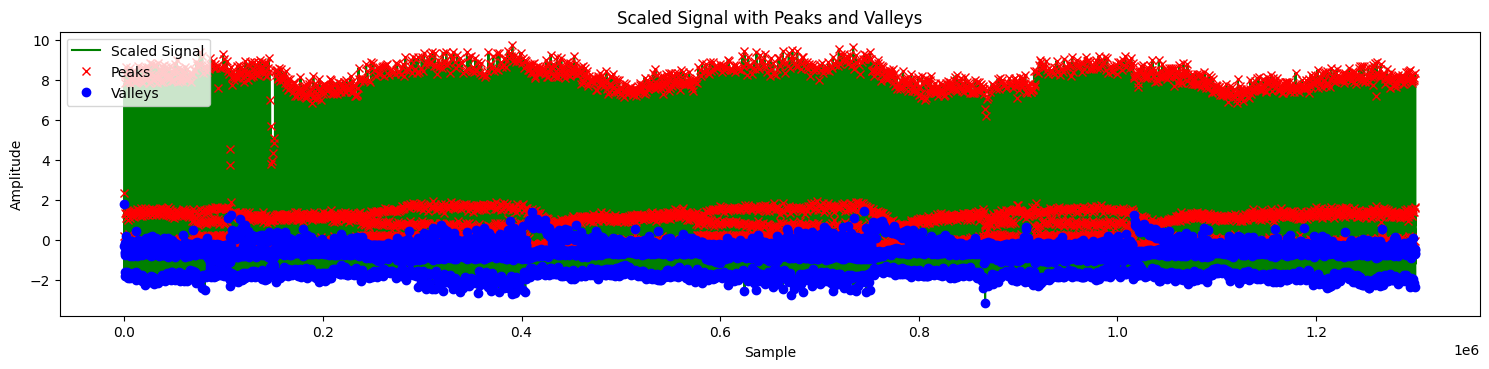

In [93]:
# Visualization of Preprocessed Signals
import matplotlib.pyplot as plt

def visualize_preprocessed_signals(processed_signals, file_names):
    
    for i, result in enumerate(processed_signals):
        plt.figure(figsize=(15, 10))
        
       

        
        plt.subplot(3, 1, 3)
        plt.plot(result['scaled'], label='Scaled Signal', color='green')
        plt.plot(result['peaks'], result['scaled'][result['peaks']], "x", label='Peaks', color='red')
        plt.plot(result['valleys'], result['scaled'][result['valleys']], "o", label='Valleys', color='blue')
        plt.title('Scaled Signal with Peaks and Valleys')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.tight_layout()
        plt.show()


visualize_preprocessed_signals(processed_signals, file_names)



Analyzing record: 100
Optimal window size: 717 samples (1.99 seconds)
Number of segmented windows: 3630


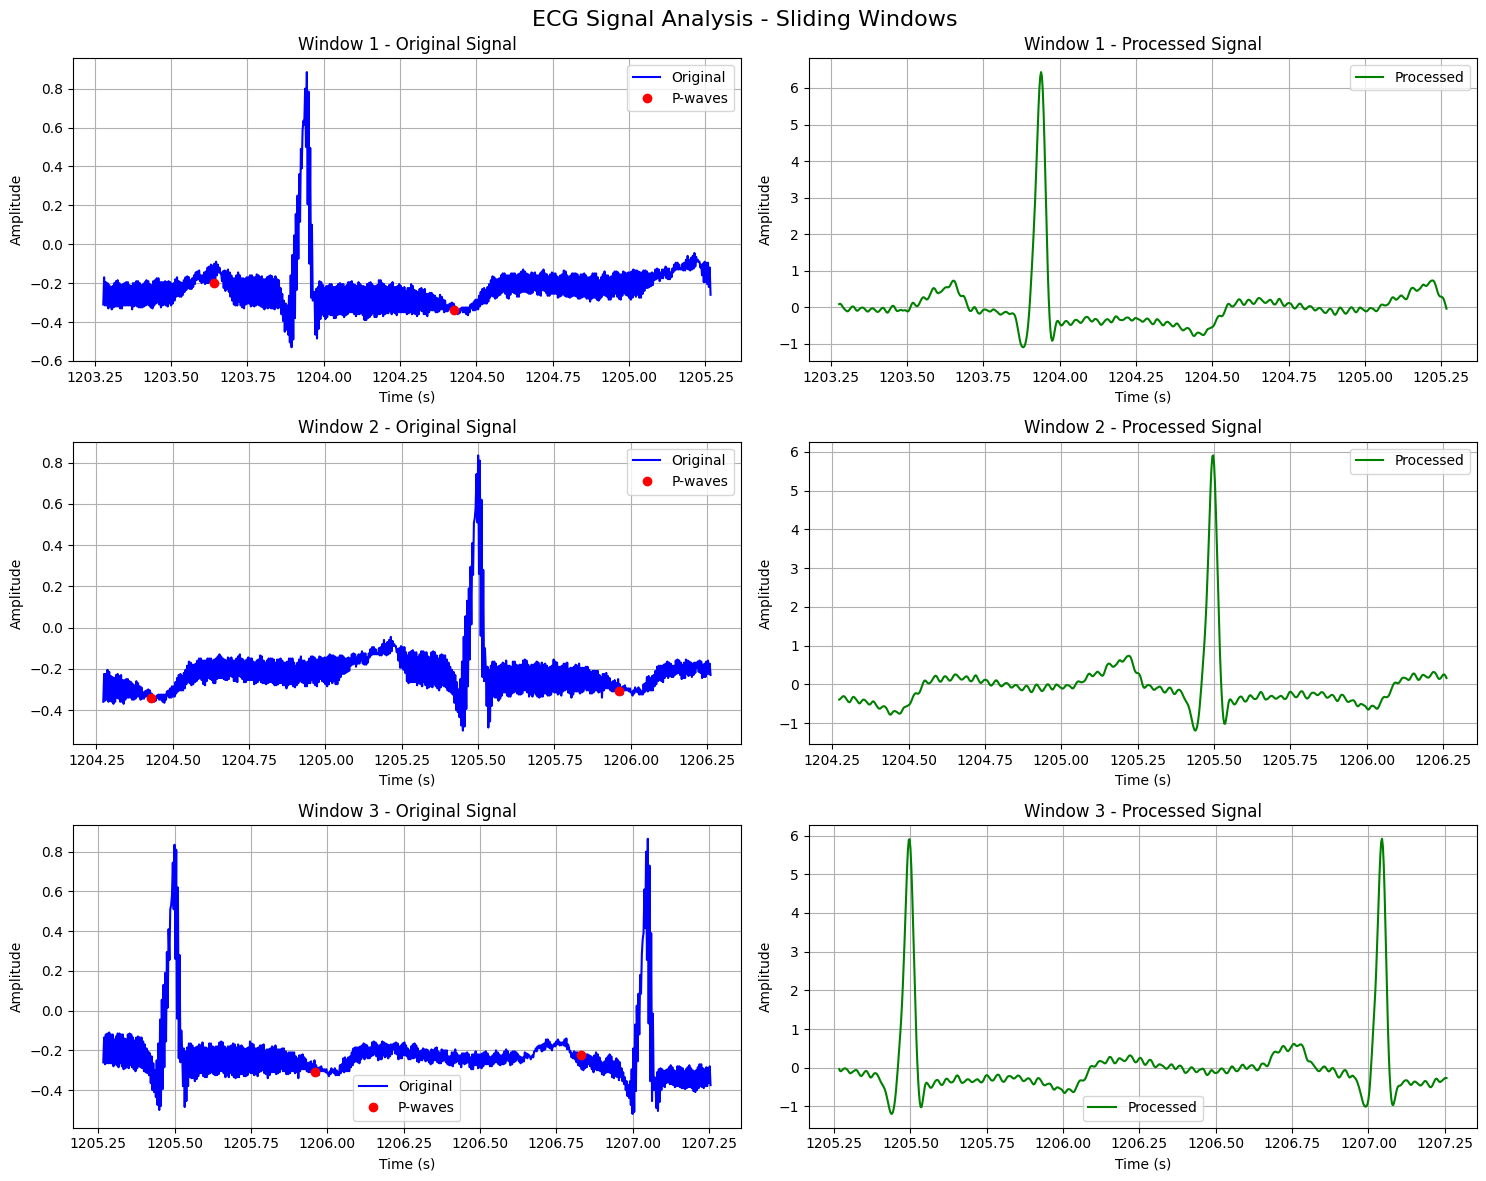


Analyzing record: 101
Optimal window size: 880 samples (2.44 seconds)
Number of segmented windows: 2953


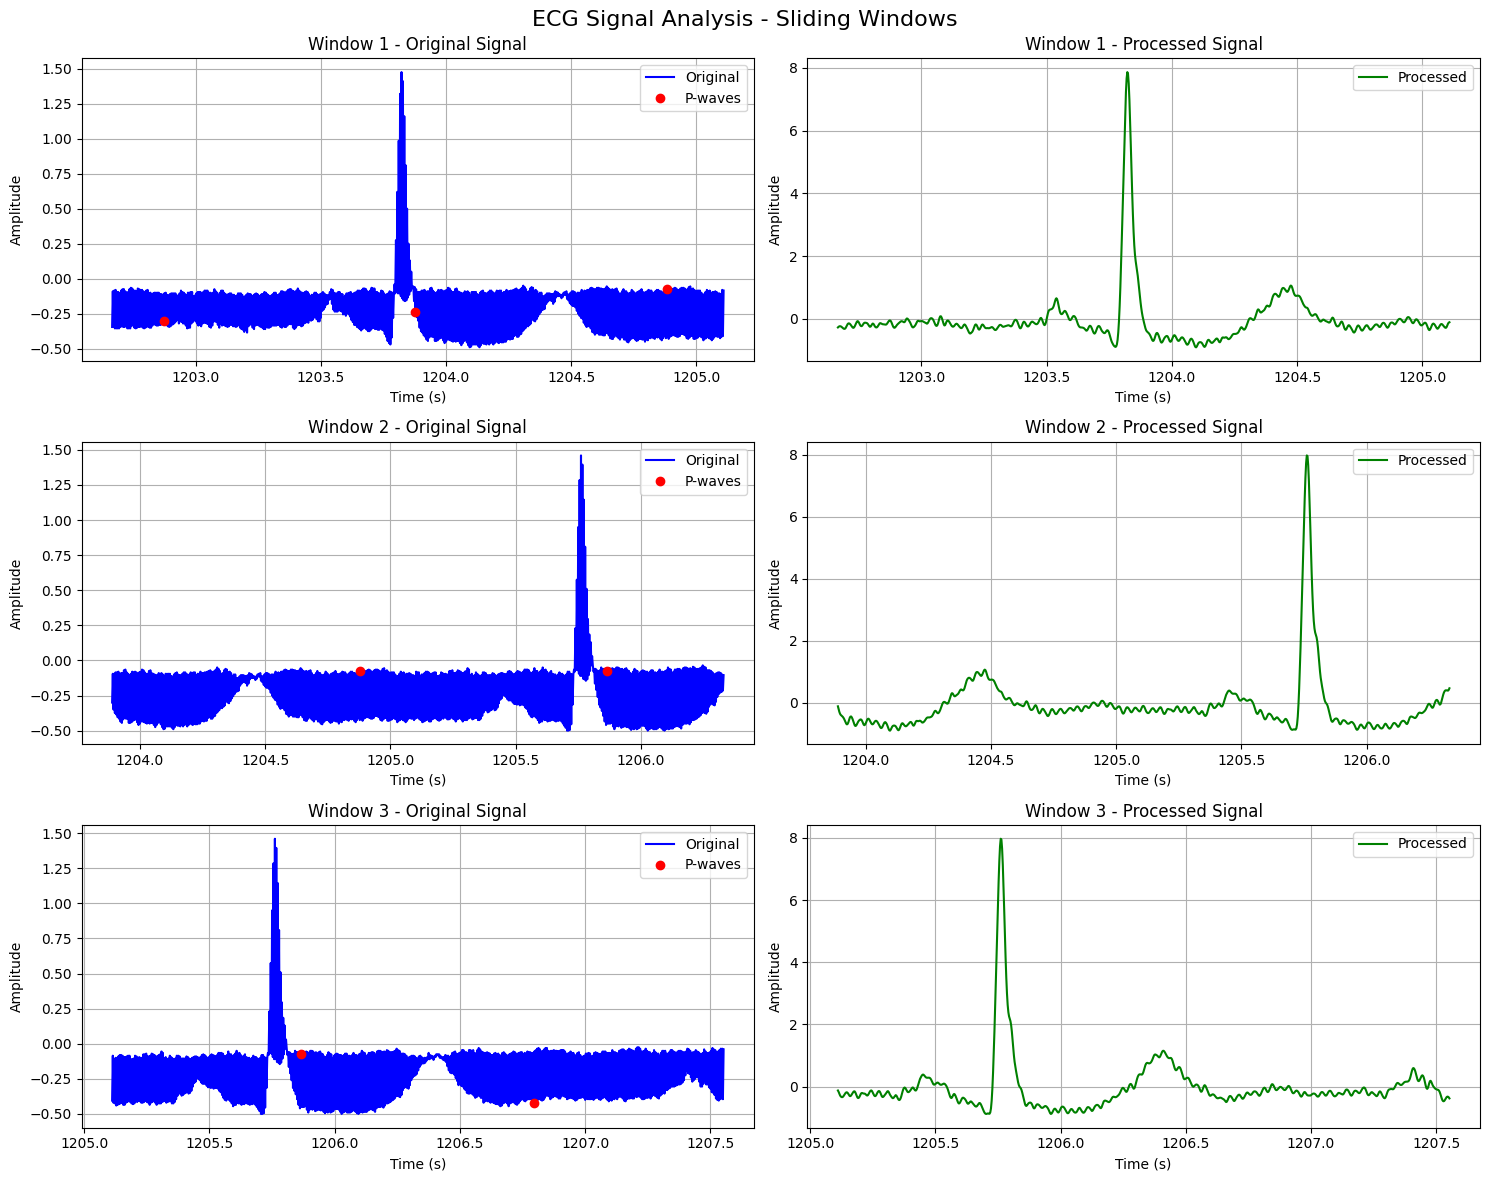


Analyzing record: 103
Optimal window size: 780 samples (2.17 seconds)
Number of segmented windows: 3332


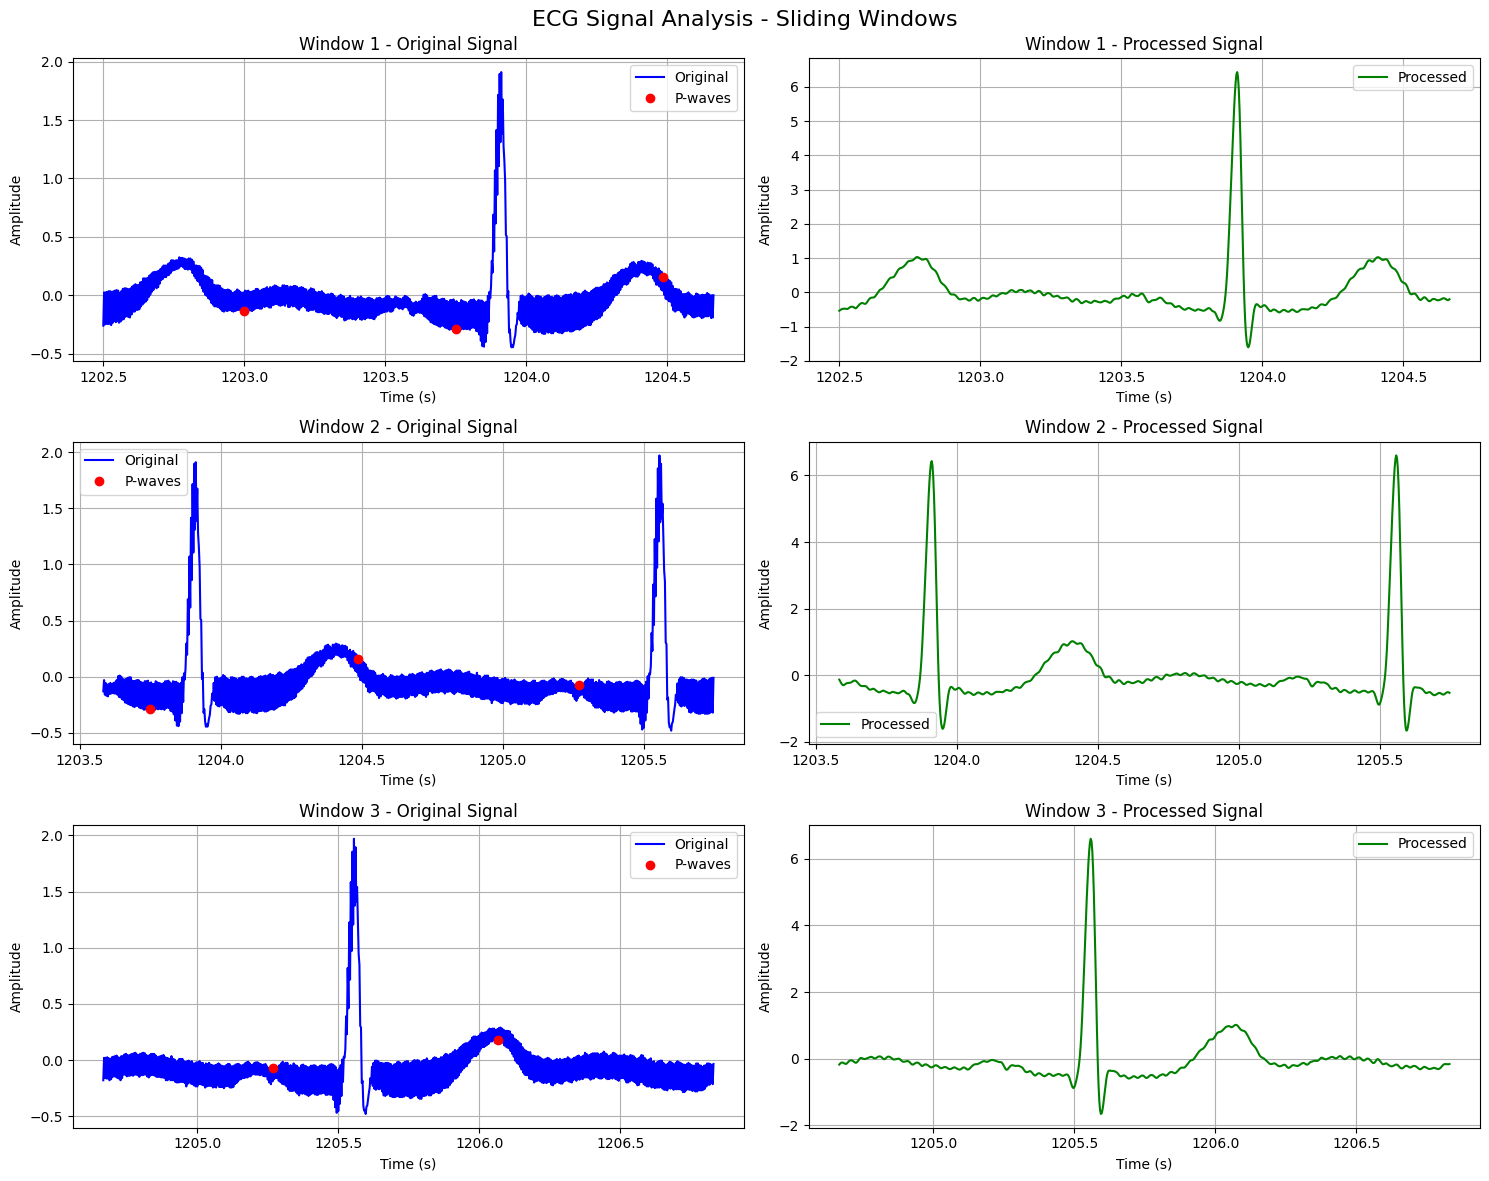


Analyzing record: 106
Optimal window size: 907 samples (2.52 seconds)
Number of segmented windows: 2868


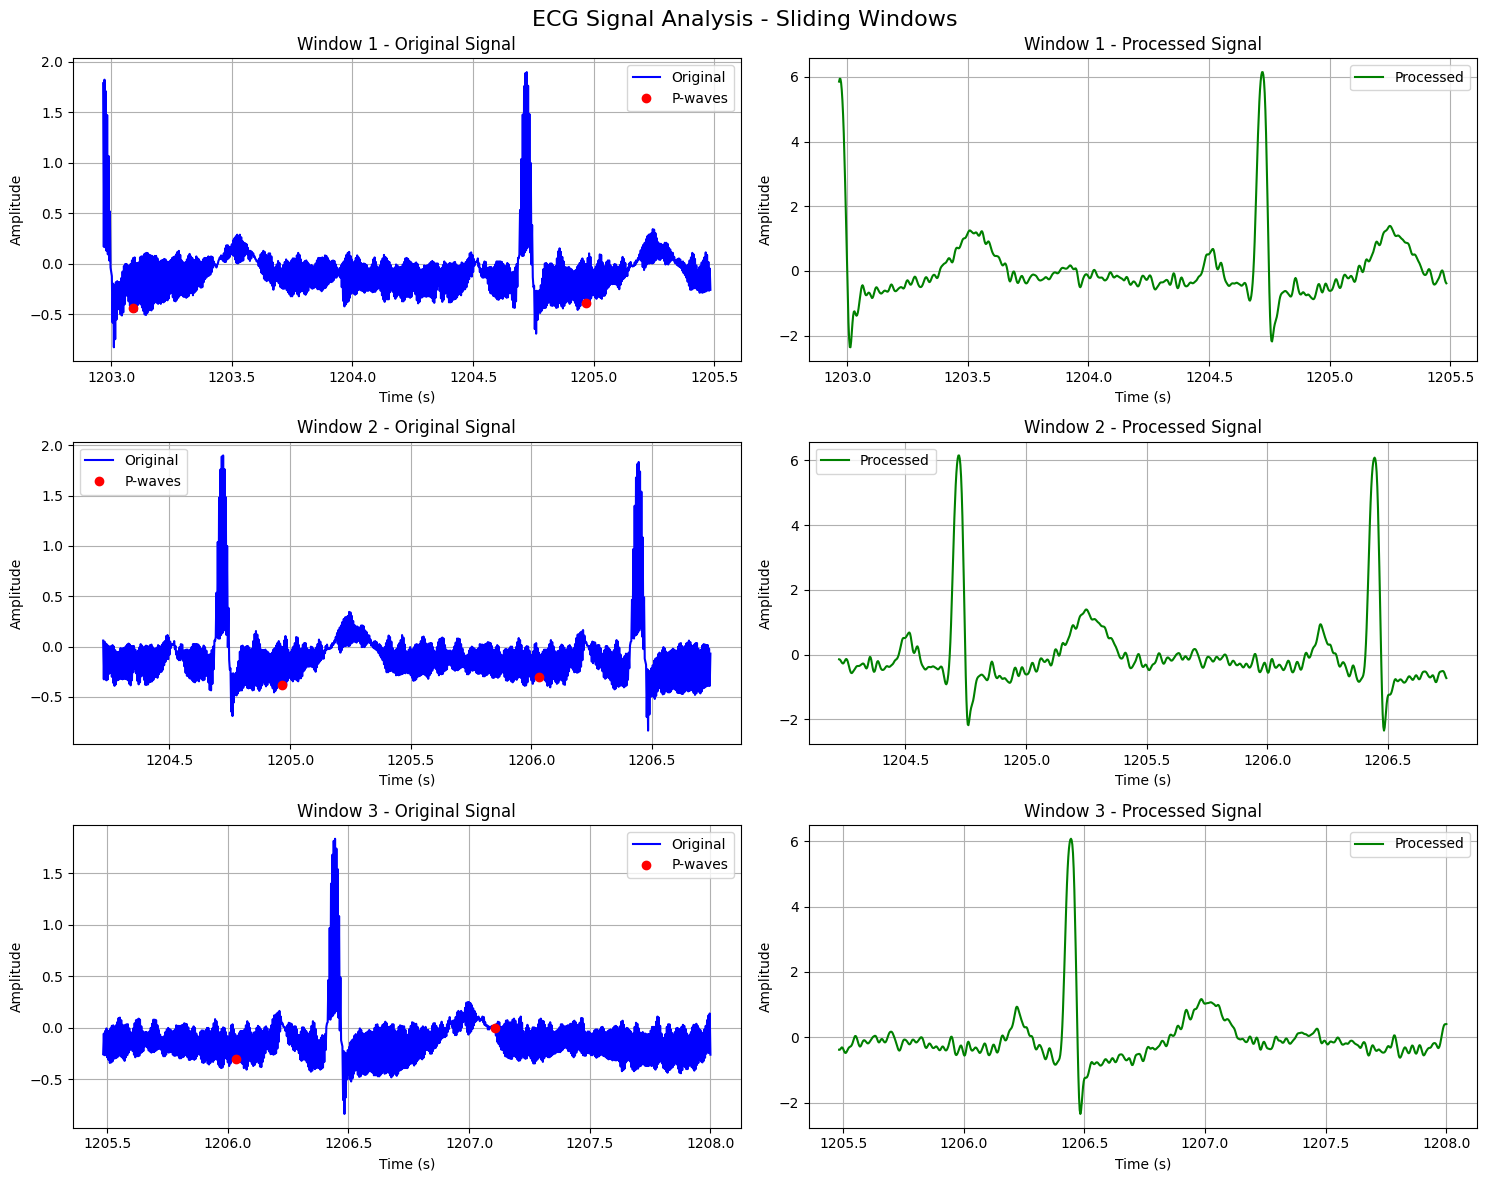


Analyzing record: 117
Optimal window size: 1062 samples (2.95 seconds)
Number of segmented windows: 2447


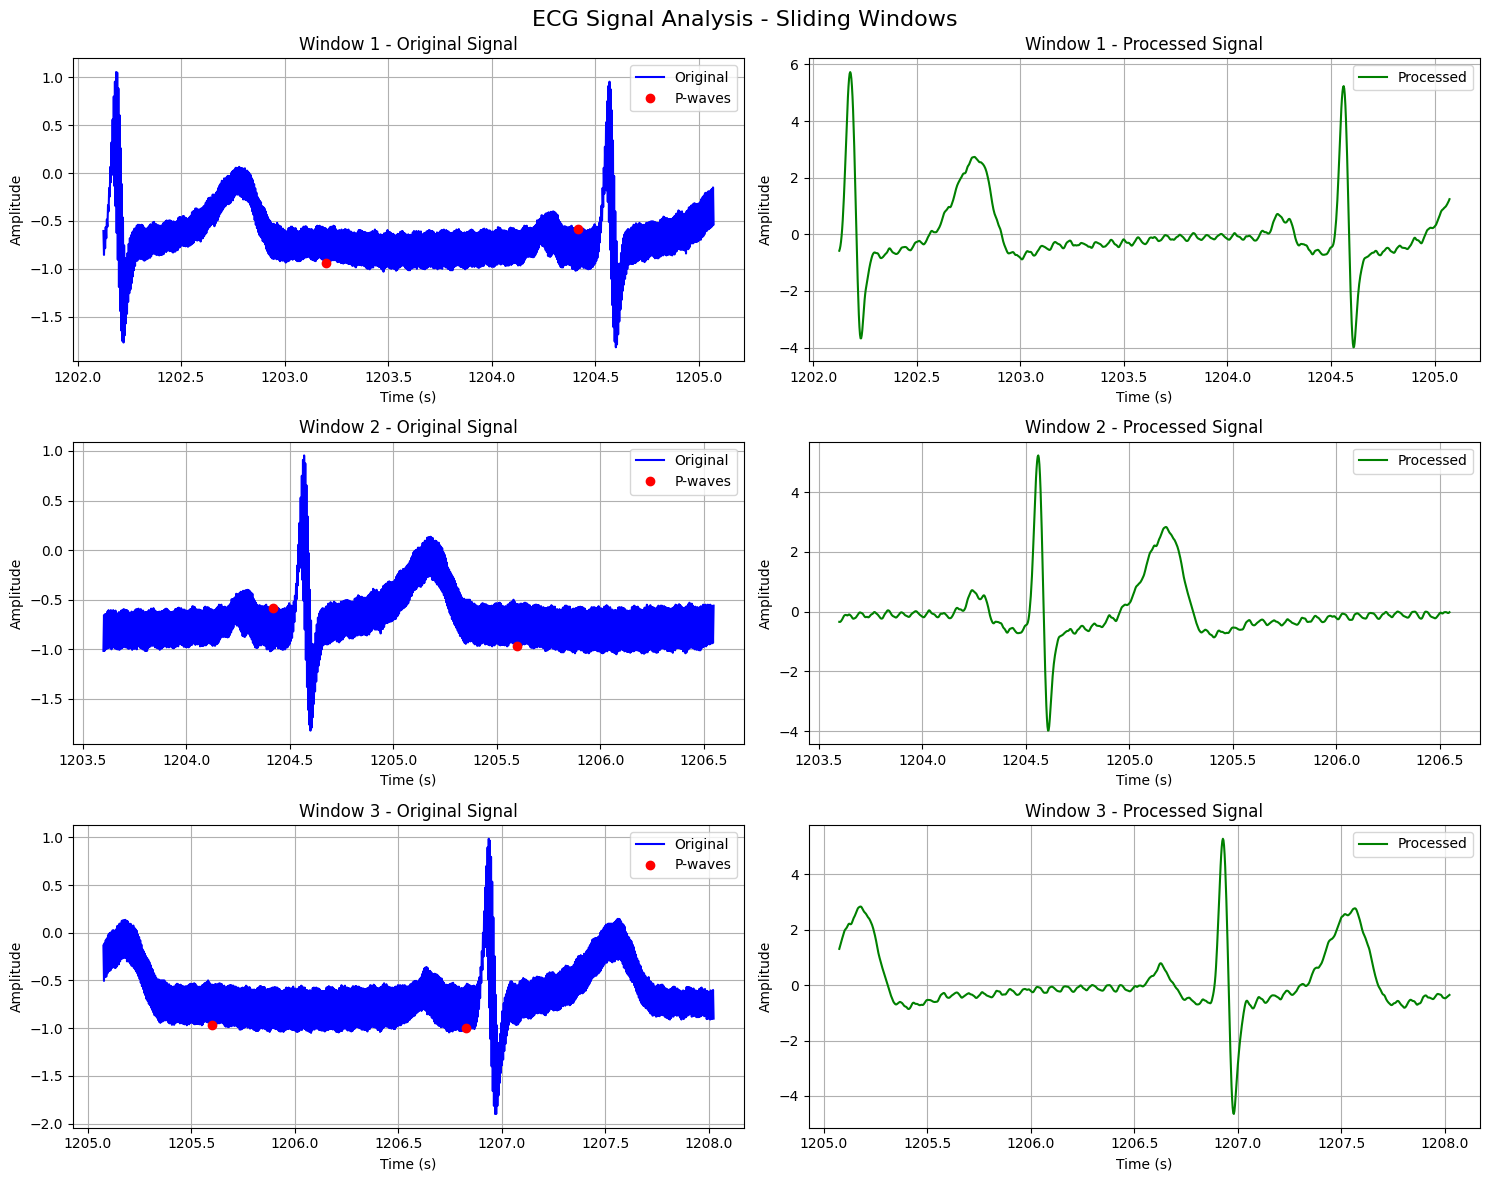


Analyzing record: 119
Optimal window size: 820 samples (2.28 seconds)
Number of segmented windows: 3169


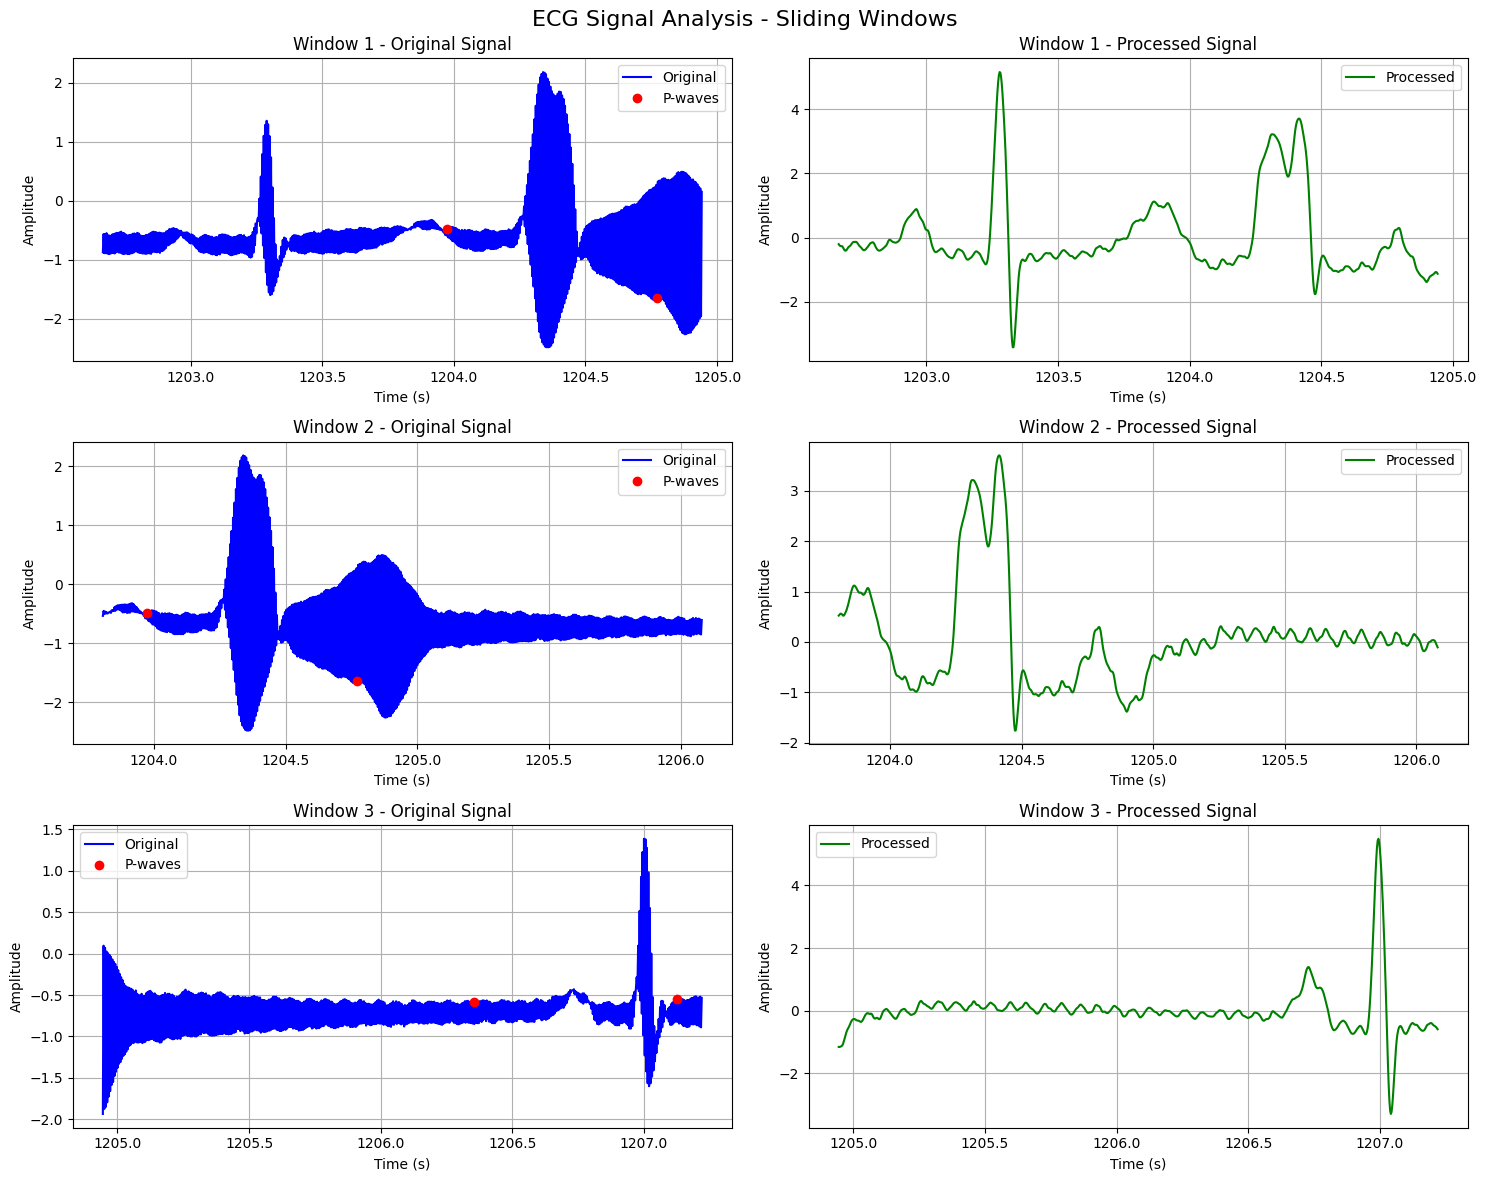


Analyzing record: 122
Optimal window size: 657 samples (1.82 seconds)
Number of segmented windows: 3962


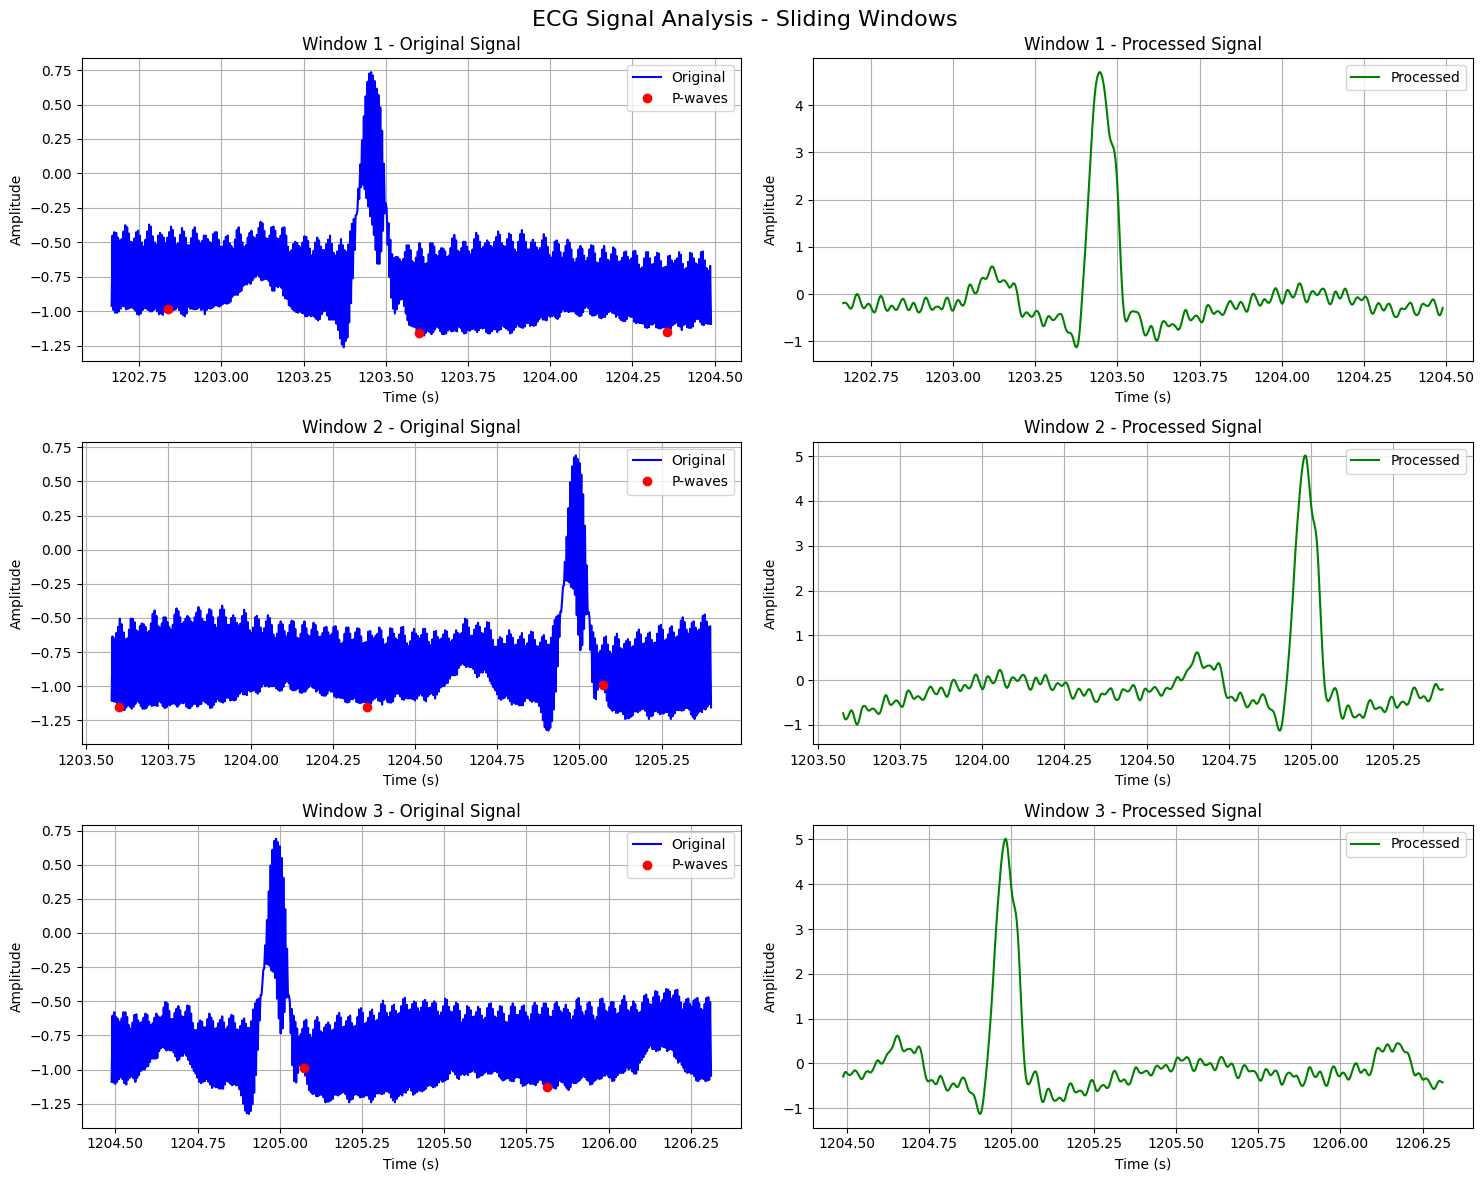


Analyzing record: 207
Optimal window size: 852 samples (2.37 seconds)
Number of segmented windows: 3050


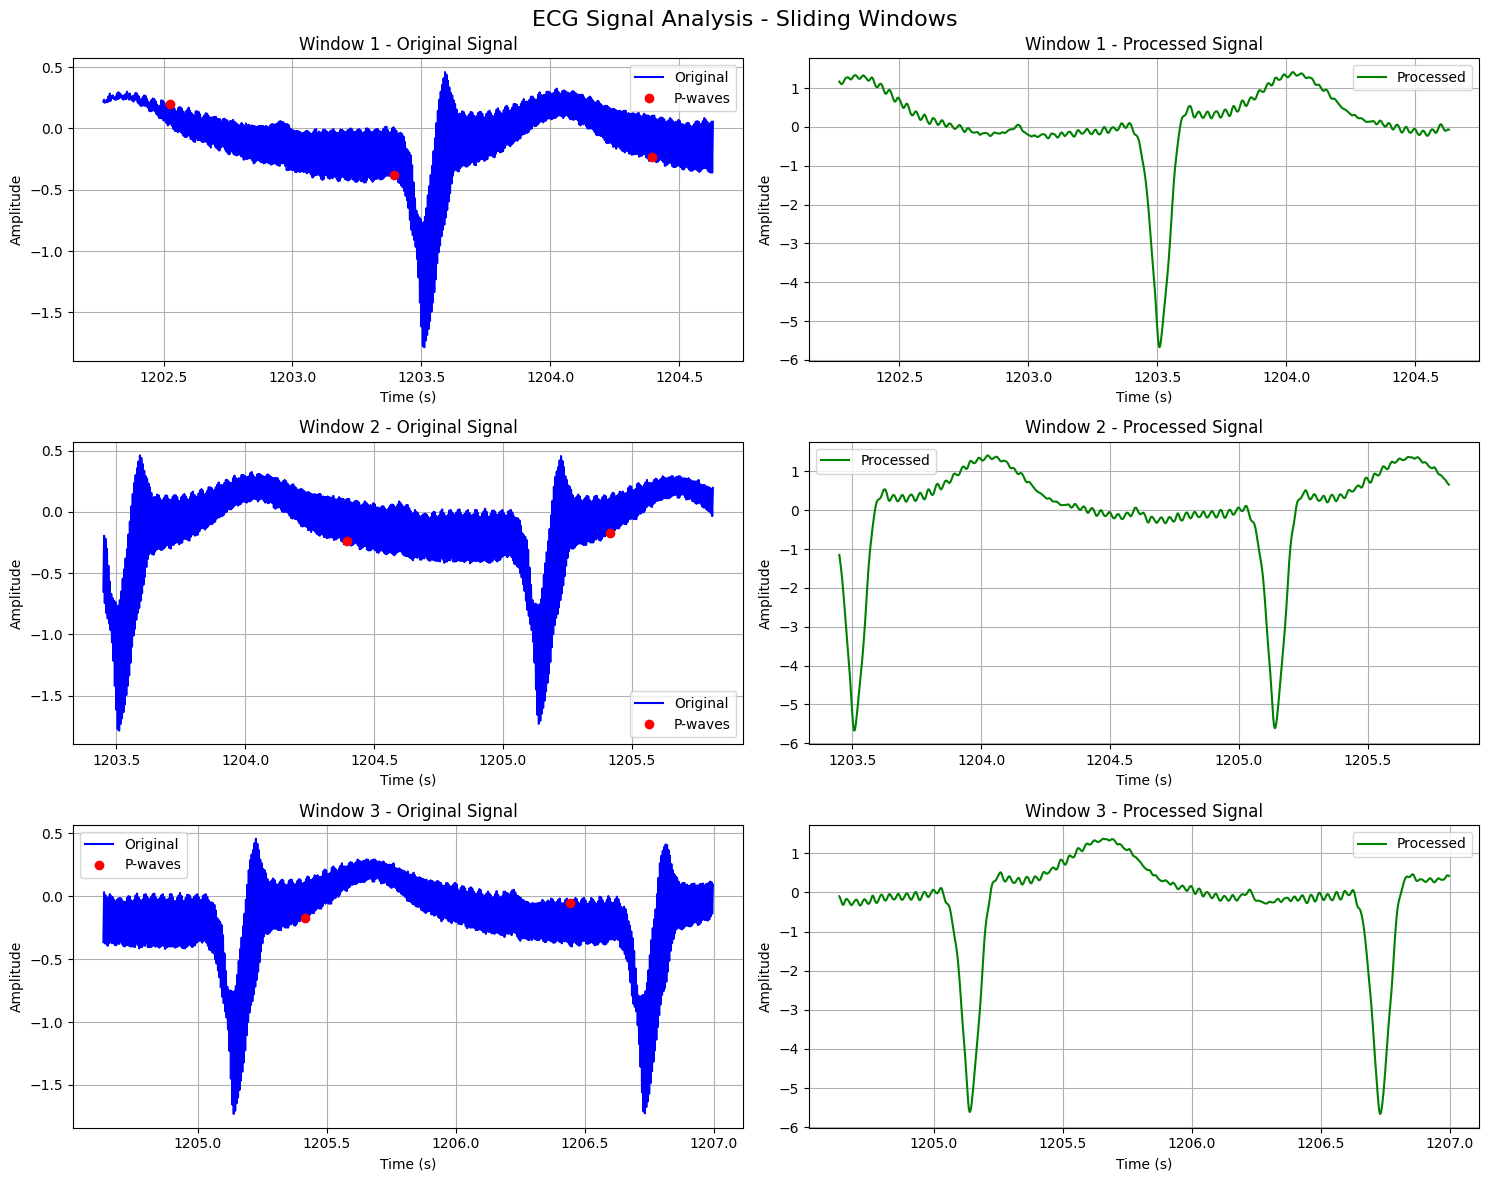


Analyzing record: 214
Optimal window size: 730 samples (2.03 seconds)
Number of segmented windows: 3560


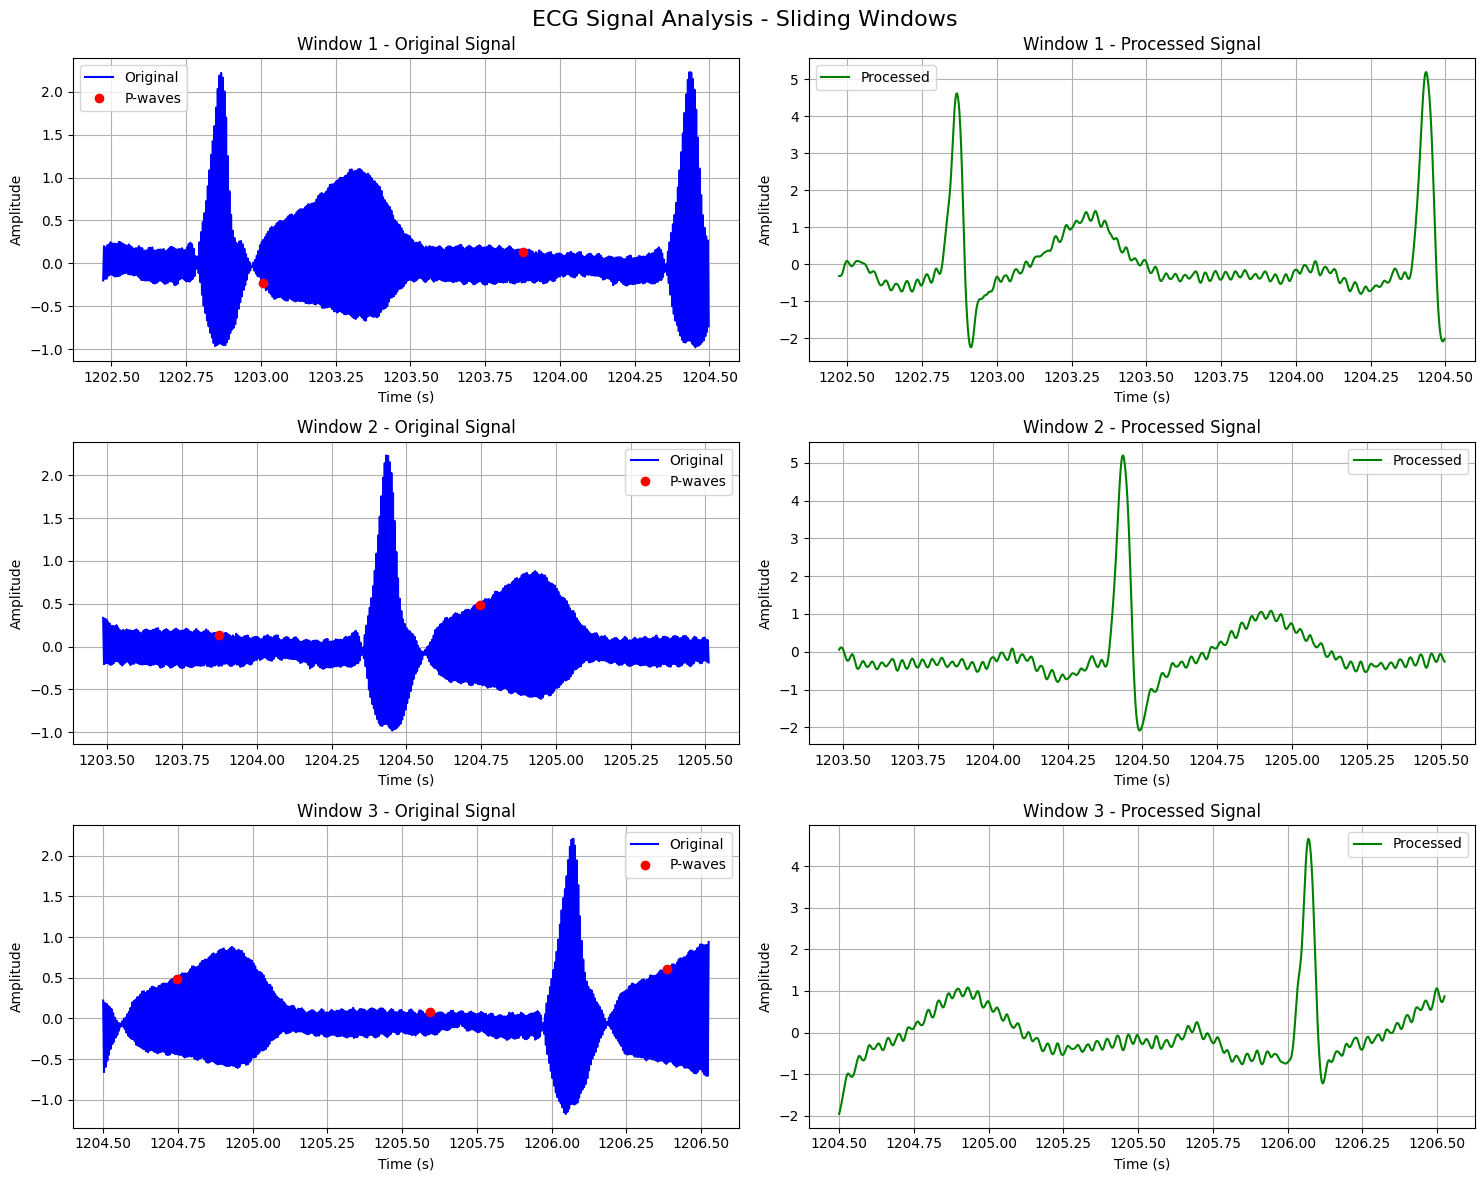


Analyzing record: 222
Optimal window size: 755 samples (2.10 seconds)
Number of segmented windows: 3447


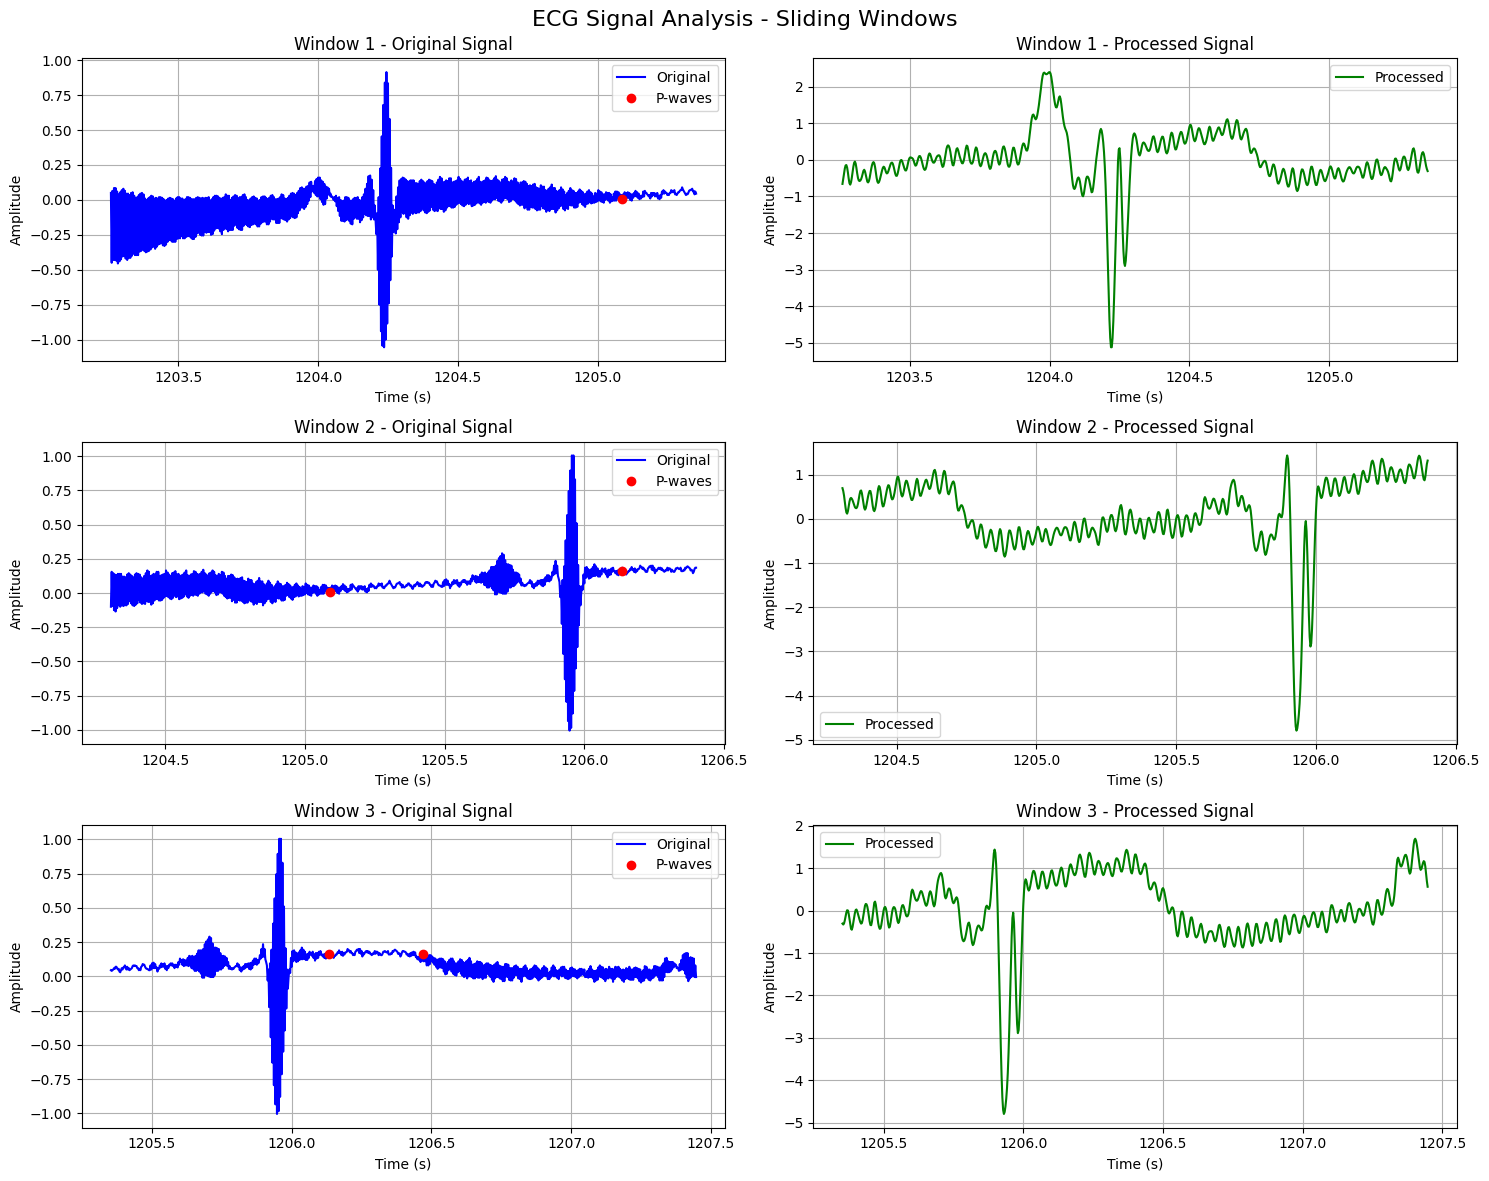


Analyzing record: 223
Optimal window size: 635 samples (1.76 seconds)
Number of segmented windows: 4099


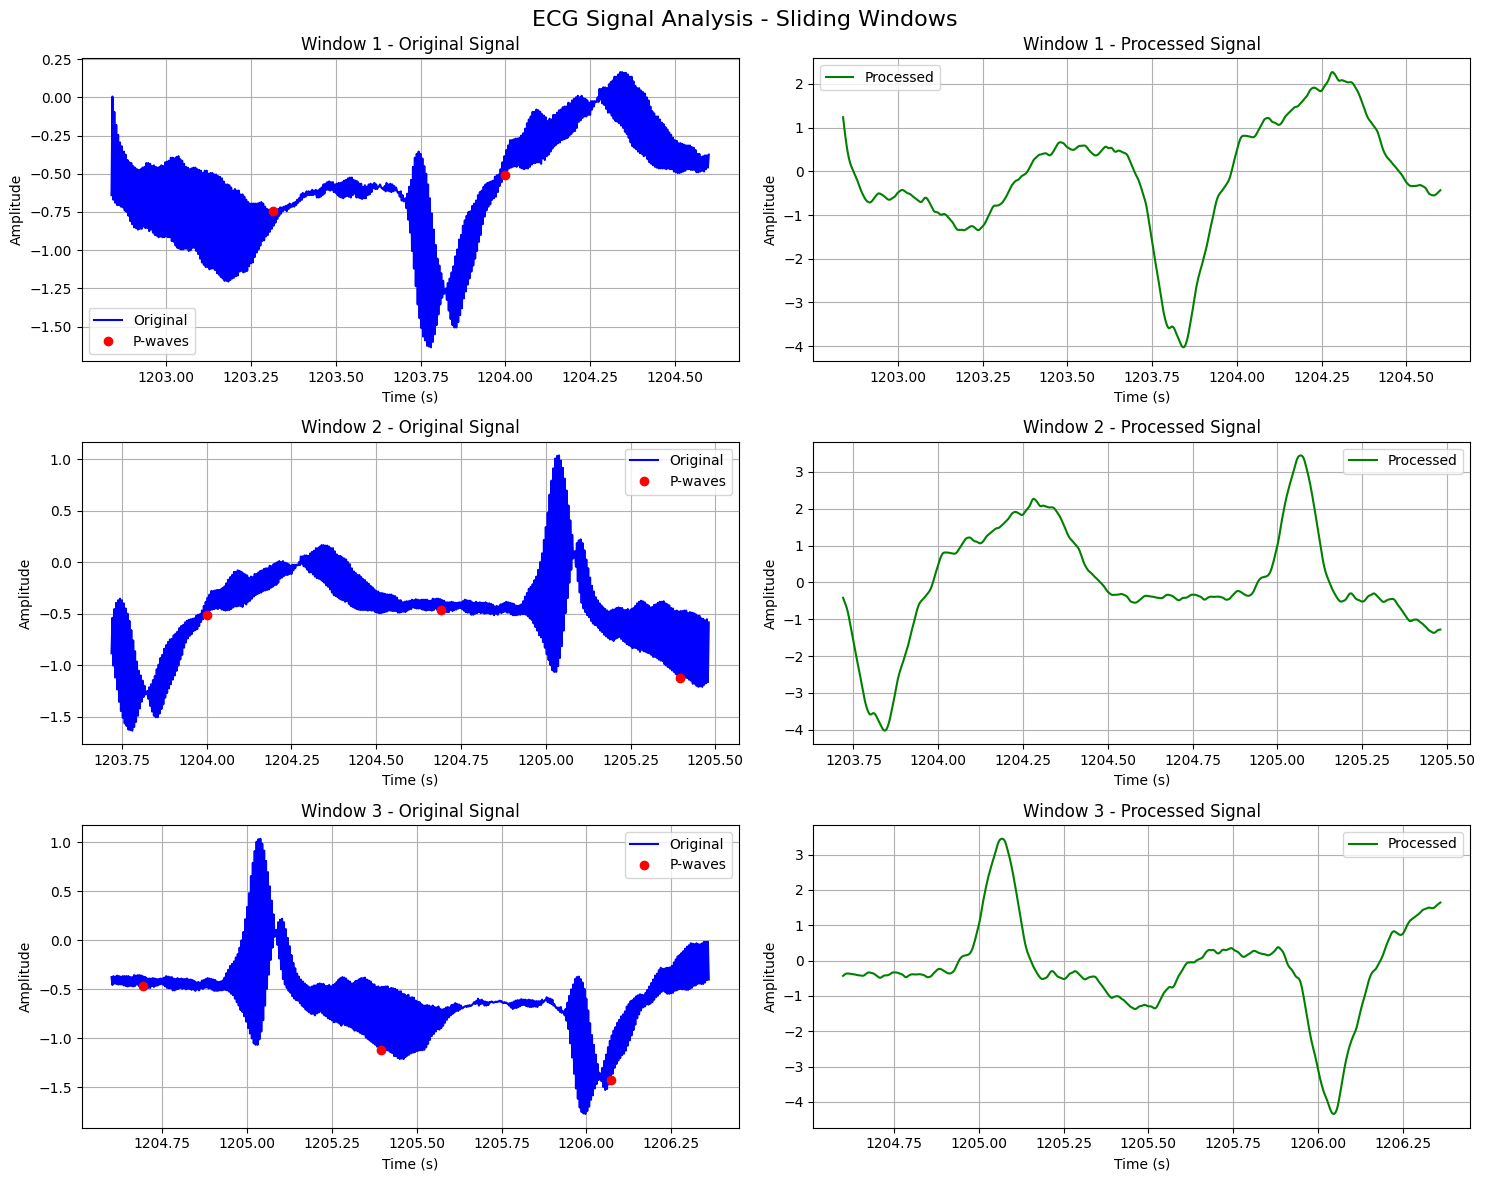


Analyzing record: 231
Optimal window size: 815 samples (2.26 seconds)
Number of segmented windows: 3193


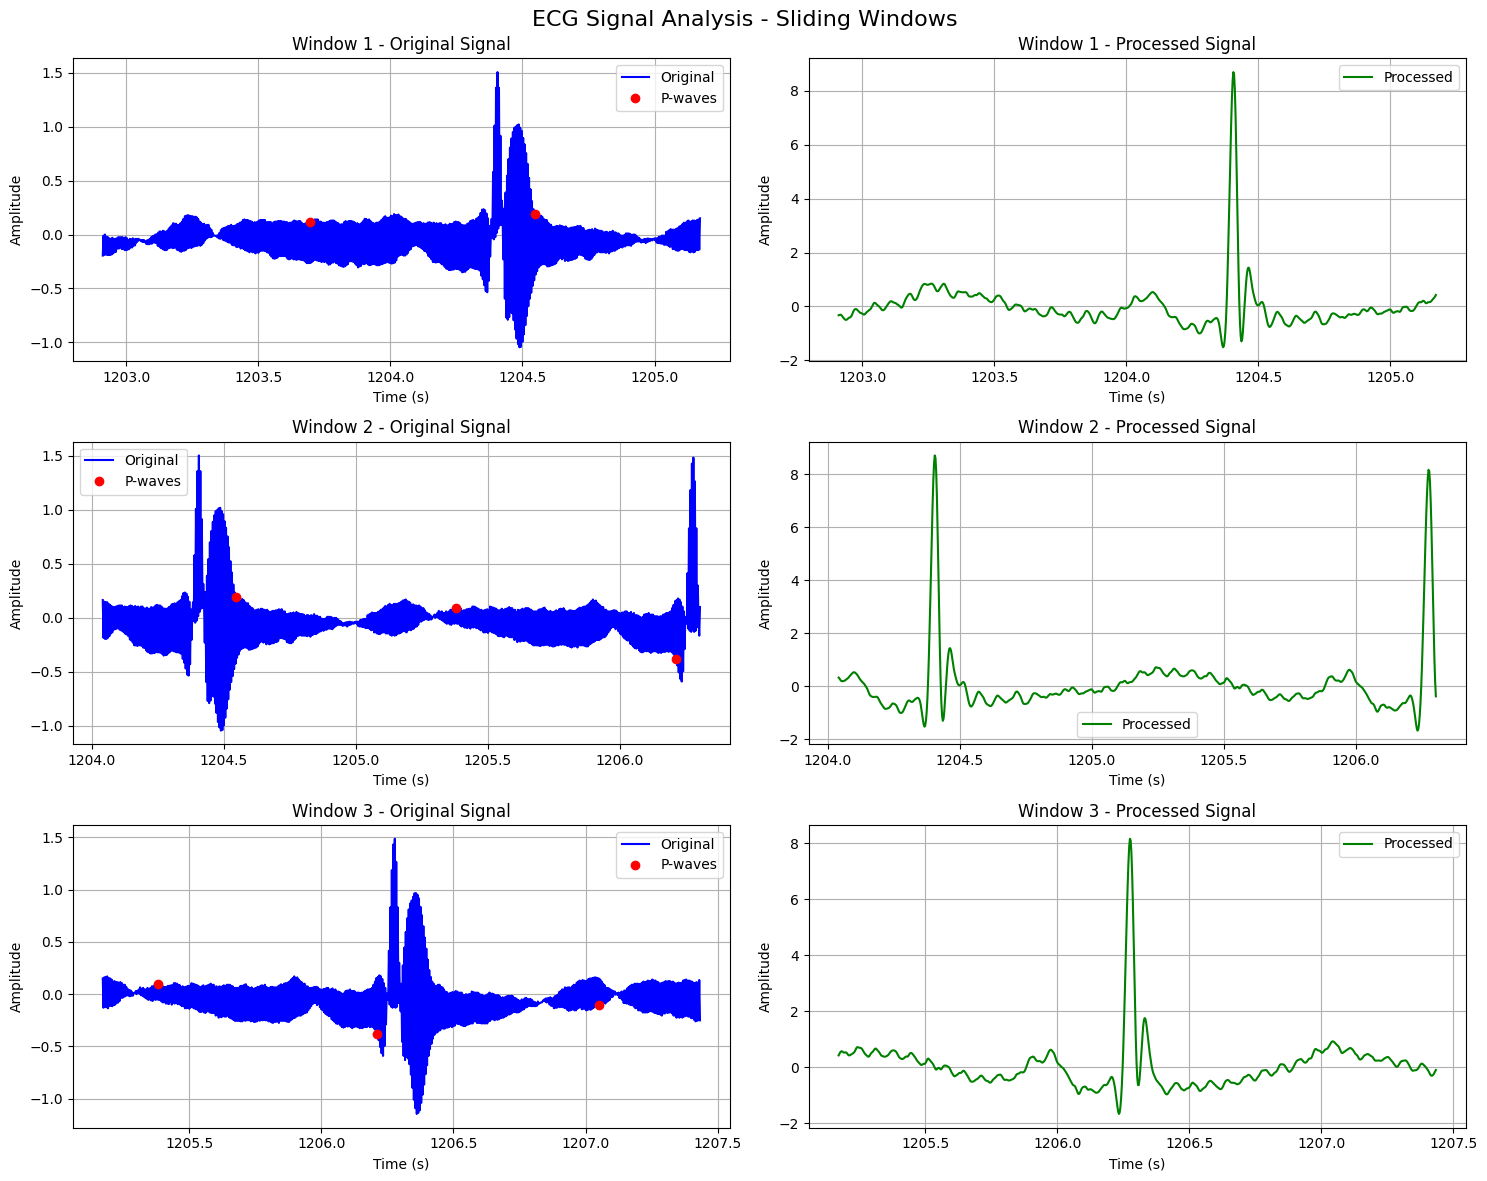

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# Find the optimal window size based on P-wave annotations and signal characteristics.
def find_optimal_window(signal, annotations, fs=360):
    
    if len(annotations) < 2:
        return fs 
    
    # Calculating distances between consecutive P-waves
    p_wave_distances = np.diff(annotations)
    
    
    median_distance = np.median(p_wave_distances)
    std_distance = np.std(p_wave_distances)
    
    
    optimal_window = int(2.5 * median_distance)
    
    
    optimal_window = max(min(optimal_window, 5 * fs), fs)
    
    return optimal_window
# Creating overlapping windows of the signal.
def create_sliding_windows(signal, window_size, overlap=0.5):
    
    step_size = int(window_size * (1 - overlap))
    windows = []
    window_starts = []
    
    for start in range(0, len(signal) - window_size + 1, step_size):
        end = start + window_size
        windows.append(signal[start:end])
        window_starts.append(start)
    
    return windows, window_starts
#Segment the signal into optimal windows and analyze P-wave presence.
    
def optimal_window_segmentation(signal, window_size, annotations):
    
    segmented_windows, _ = create_sliding_windows(signal, window_size)
    
    p_wave_counts = []
    for window_start in range(0, len(signal) - window_size + 1, int(window_size * 0.5)):  # Overlapping step
        window_end = window_start + window_size
        window_annotations = annotations[(annotations >= window_start) & (annotations < window_end)]
        p_wave_counts.append(len(window_annotations))
    
    return segmented_windows, p_wave_counts
# Plotting multiple consecutive windows of the signal with annotations.
def plot_sliding_window_analysis(signal, processed_signal, annotations, window_size, overlap=0.5, n_windows=3):
    
    windows, window_starts = create_sliding_windows(signal, window_size, overlap)
    processed_windows, _ = create_sliding_windows(processed_signal, window_size, overlap)
    
    
    start_idx = len(windows) // 3
    display_windows = windows[start_idx:start_idx + n_windows]
    display_processed = processed_windows[start_idx:start_idx + n_windows]
    display_starts = window_starts[start_idx:start_idx + n_windows]
    
    
    fig, axes = plt.subplots(n_windows, 2, figsize=(15, 4 * n_windows))
    fig.suptitle('ECG Signal Analysis - Sliding Windows', fontsize=16)
    
    for i, (window, proc_window, start) in enumerate(zip(display_windows, display_processed, display_starts)):
        time = np.arange(start, start + len(window)) / 360  
        
        # Plot original signal
        axes[i, 0].plot(time, window, 'b-', label='Original')
        axes[i, 0].set_title(f'Window {i+1} - Original Signal')
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 0].grid(True)
        
        # Mark P-wave annotations in this window
        window_annotations = annotations[(annotations >= start) & 
                                      (annotations < start + len(window))]
        if len(window_annotations) > 0:
            ann_times = window_annotations / 360
            axes[i, 0].plot(ann_times, window[window_annotations - start], 
                          'ro', label='P-waves')
        
       
        axes[i, 1].plot(time, proc_window, 'g-', label='Processed')
        axes[i, 1].set_title(f'Window {i+1} - Processed Signal')
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Amplitude')
        axes[i, 1].grid(True)
        
        # Add legends
        axes[i, 0].legend()
        axes[i, 1].legend()
    
    plt.tight_layout()
    return fig


for idx, record_name in enumerate(file_names):  
    print(f"\nAnalyzing record: {record_name}")
    
    # optimal window size
    optimal_window = find_optimal_window(signals[idx], annotations[idx])
    print(f"Optimal window size: {optimal_window} samples ({optimal_window/360:.2f} seconds)")
    
    # Segment the signal into optimal windows and analyze P-wave presence
    segmented_windows, p_wave_counts = optimal_window_segmentation(signals[idx], optimal_window, annotations[idx])
    print(f"Number of segmented windows: {len(segmented_windows)}")
   
    
    # Creating and displaying sliding window analysis
    fig = plot_sliding_window_analysis(
        signal=signals[idx],
        processed_signal=processed_signals[idx]['scaled'],
        annotations=annotations[idx],
        window_size=optimal_window,
        overlap=0.5,
        n_windows=3
    )
    plt.show()


In [95]:
# Calculating the overall optimal window size across multiple ECG records.
def calculate_overall_optimal_window_size(signals, annotations):
   
    optimal_windows = []
    
    for signal, annotation in zip(signals, annotations):
        optimal_window = find_optimal_window(signal, annotation)
        optimal_windows.append(optimal_window)
    
    
    overall_optimal_window = int(np.median(optimal_windows))
    
    return overall_optimal_window


overall_optimal_window = calculate_overall_optimal_window_size(signals, annotations)
print(f"Overall optimal window size: {overall_optimal_window} samples ({overall_optimal_window / 360:.2f} seconds)")



Overall optimal window size: 797 samples (2.21 seconds)



Analyzing characteristics for record: 100

Interval Statistics:
RR Intervals: Mean = 0.262s, Std = 0.103s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.745
Max Amplitude (mean ± std): 1.233 ± 2.605


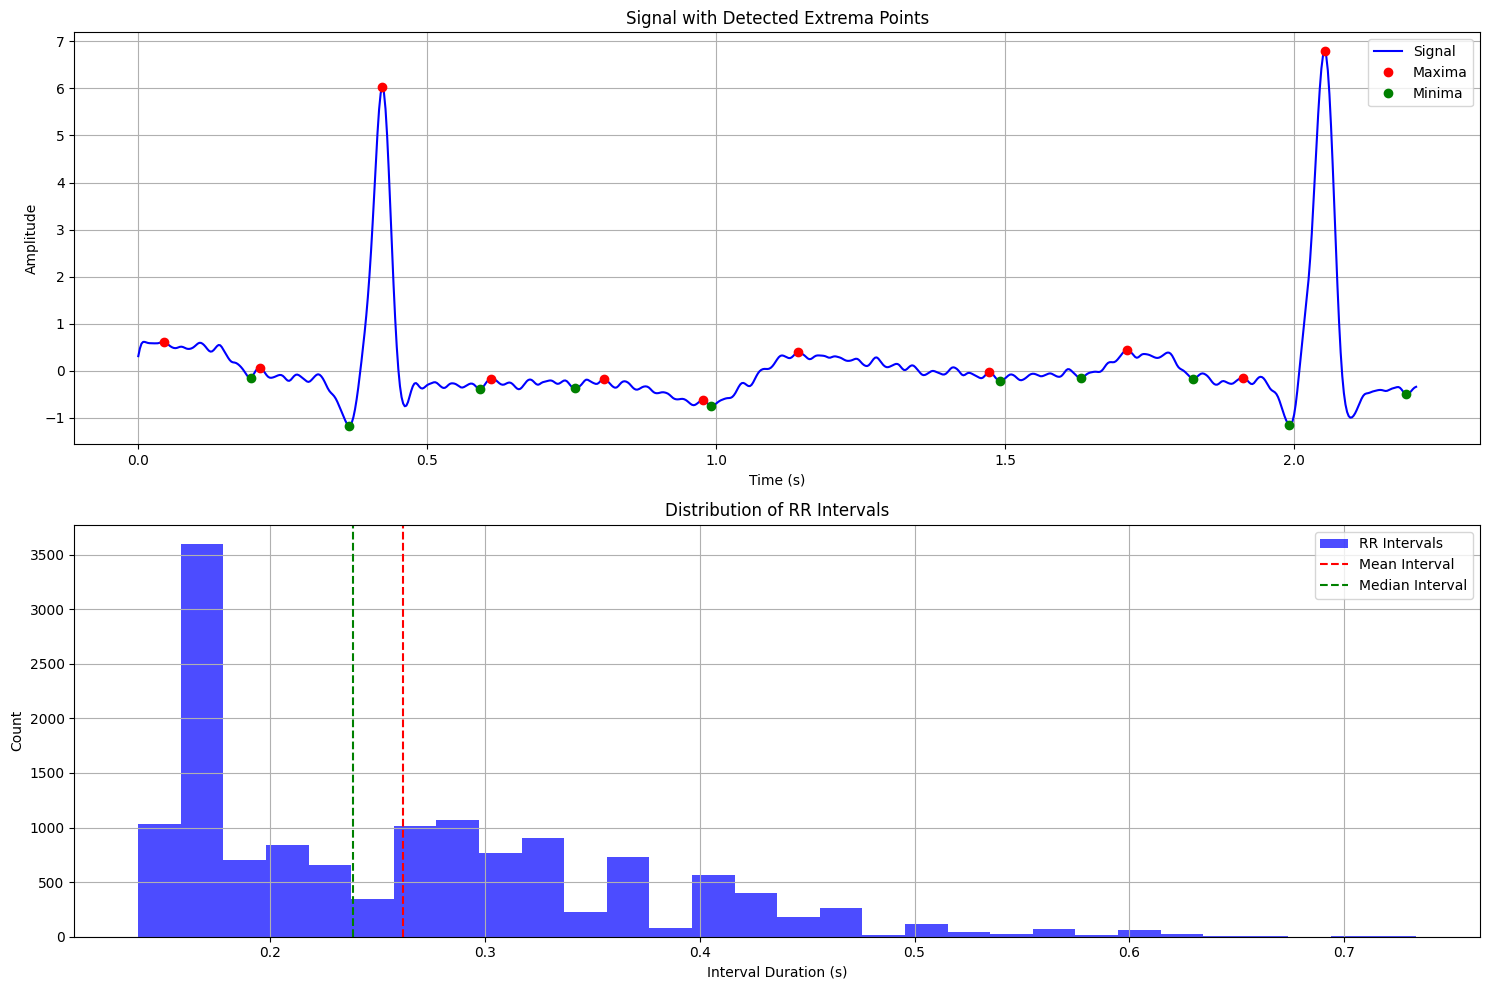


Analyzing characteristics for record: 101

Interval Statistics:
RR Intervals: Mean = 0.224s, Std = 0.080s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.458
Max Amplitude (mean ± std): 0.942 ± 2.403


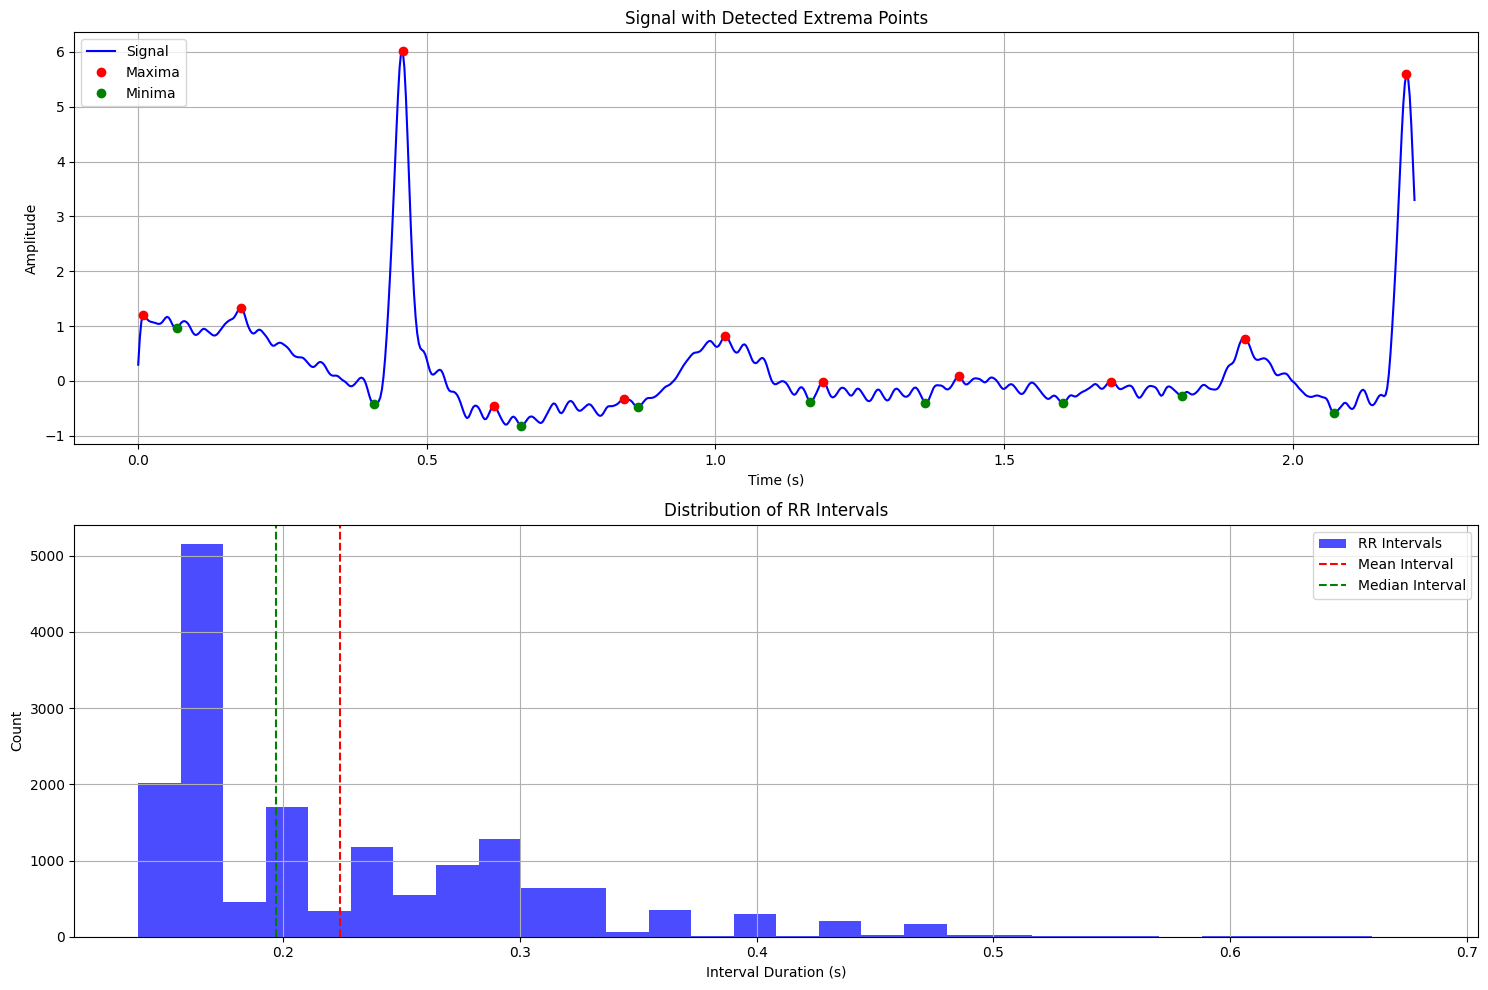


Analyzing characteristics for record: 103

Interval Statistics:
RR Intervals: Mean = 0.400s, Std = 0.117s

Amplitude Statistics:
Peak-to-Peak Amplitude: 2.408
Max Amplitude (mean ± std): 1.674 ± 2.448


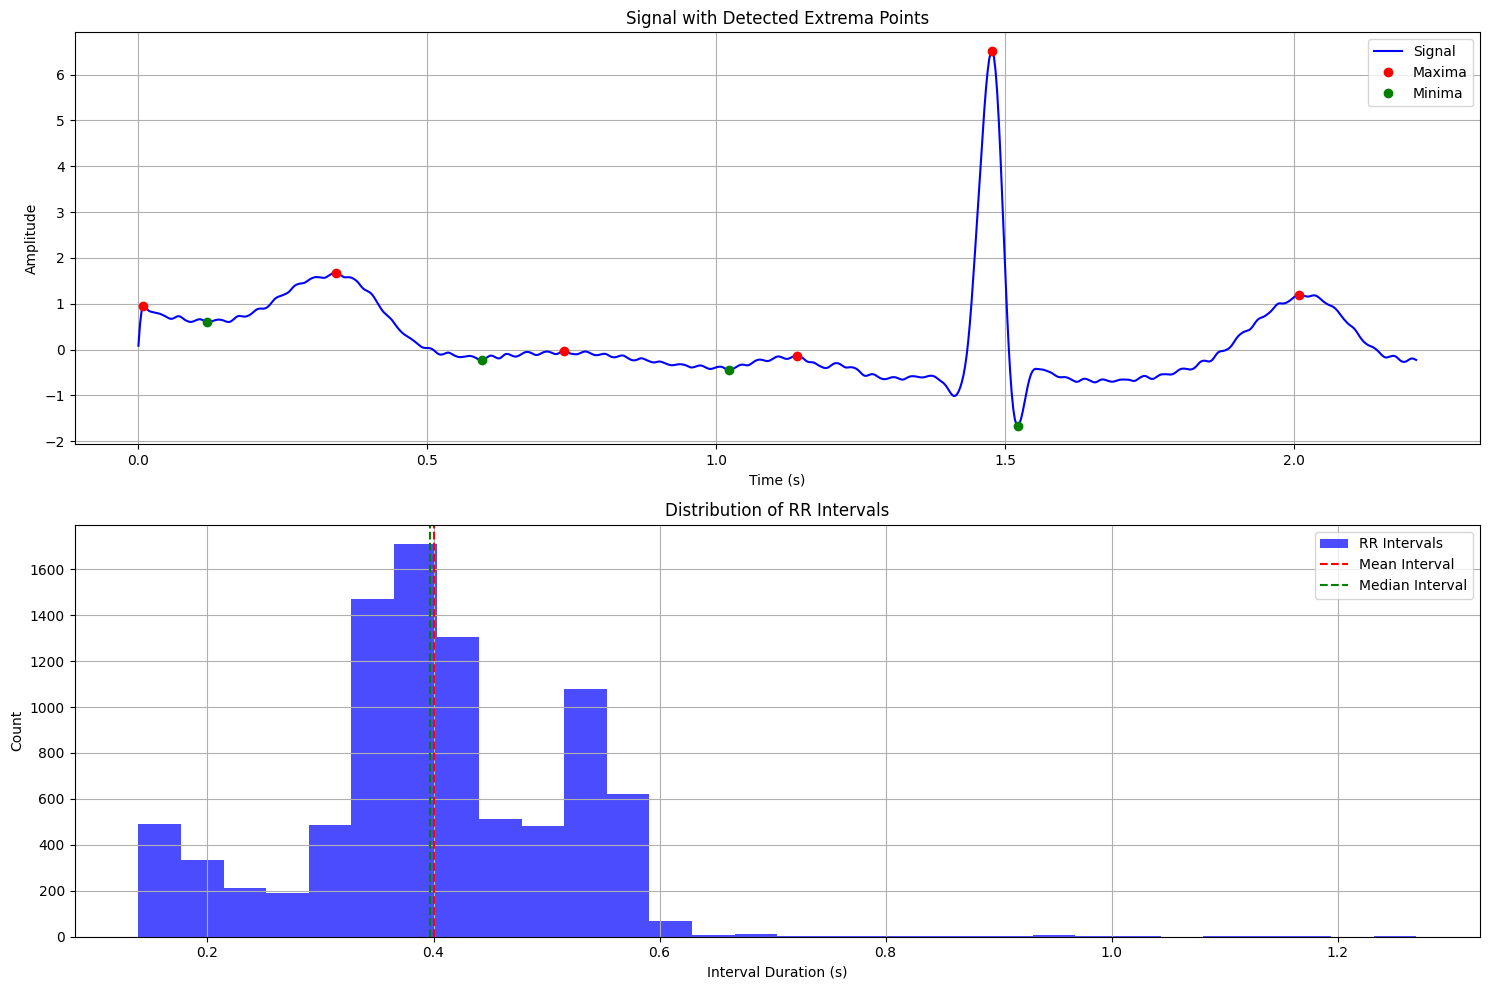


Analyzing characteristics for record: 106

Interval Statistics:
RR Intervals: Mean = 0.245s, Std = 0.096s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.455
Max Amplitude (mean ± std): 0.847 ± 1.789


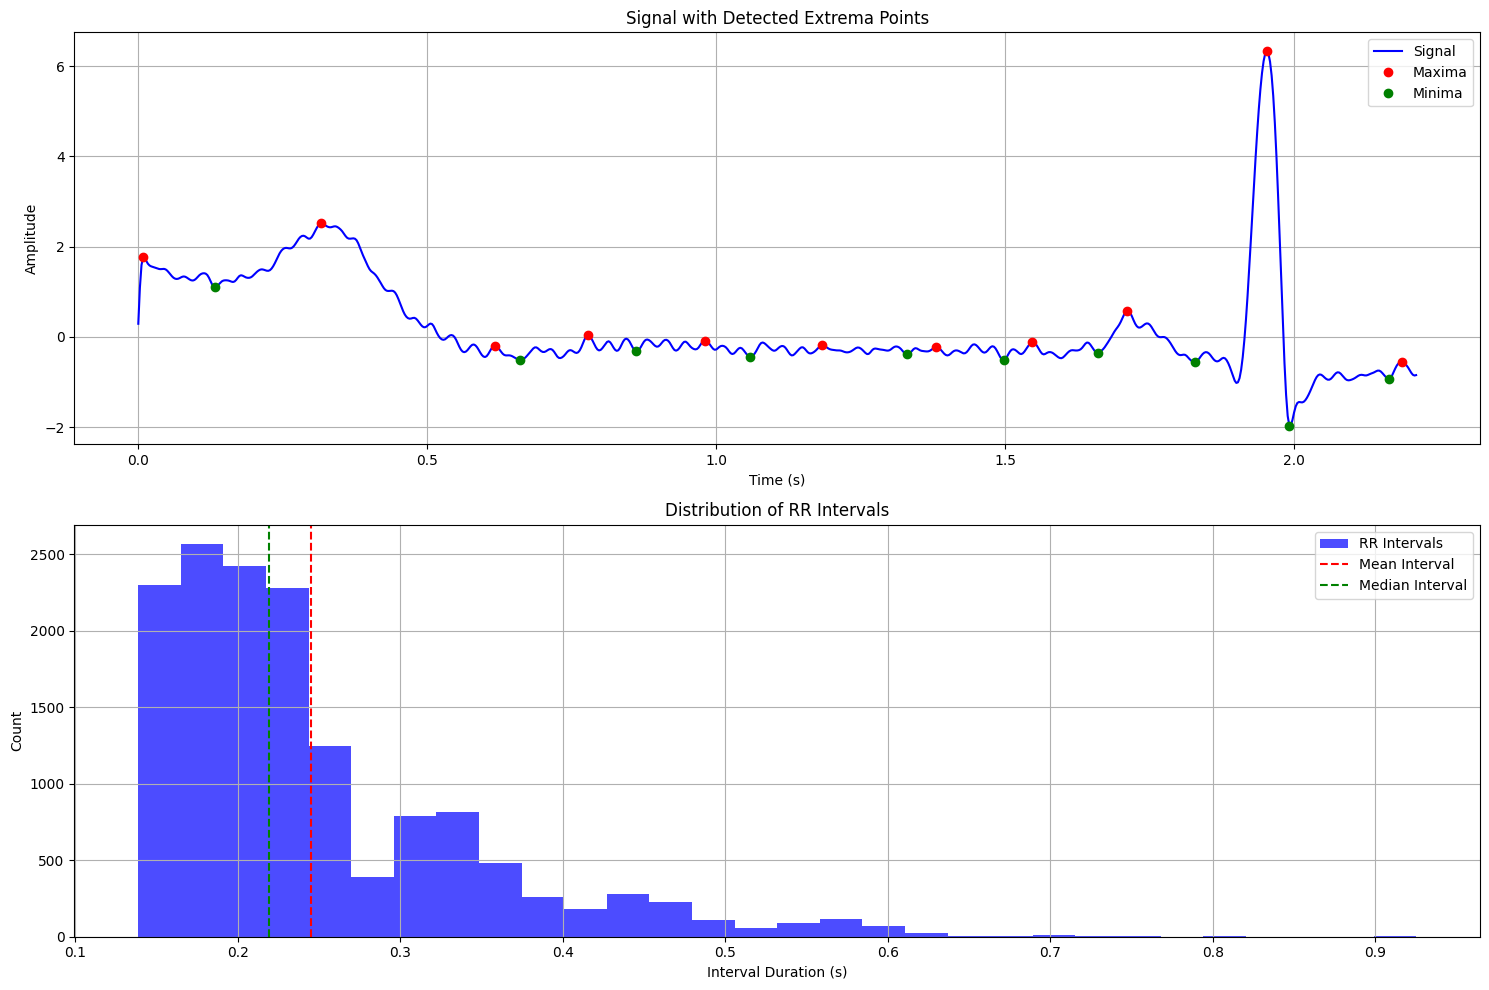


Analyzing characteristics for record: 117

Interval Statistics:
RR Intervals: Mean = 0.256s, Std = 0.092s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.584
Max Amplitude (mean ± std): 0.791 ± 1.809


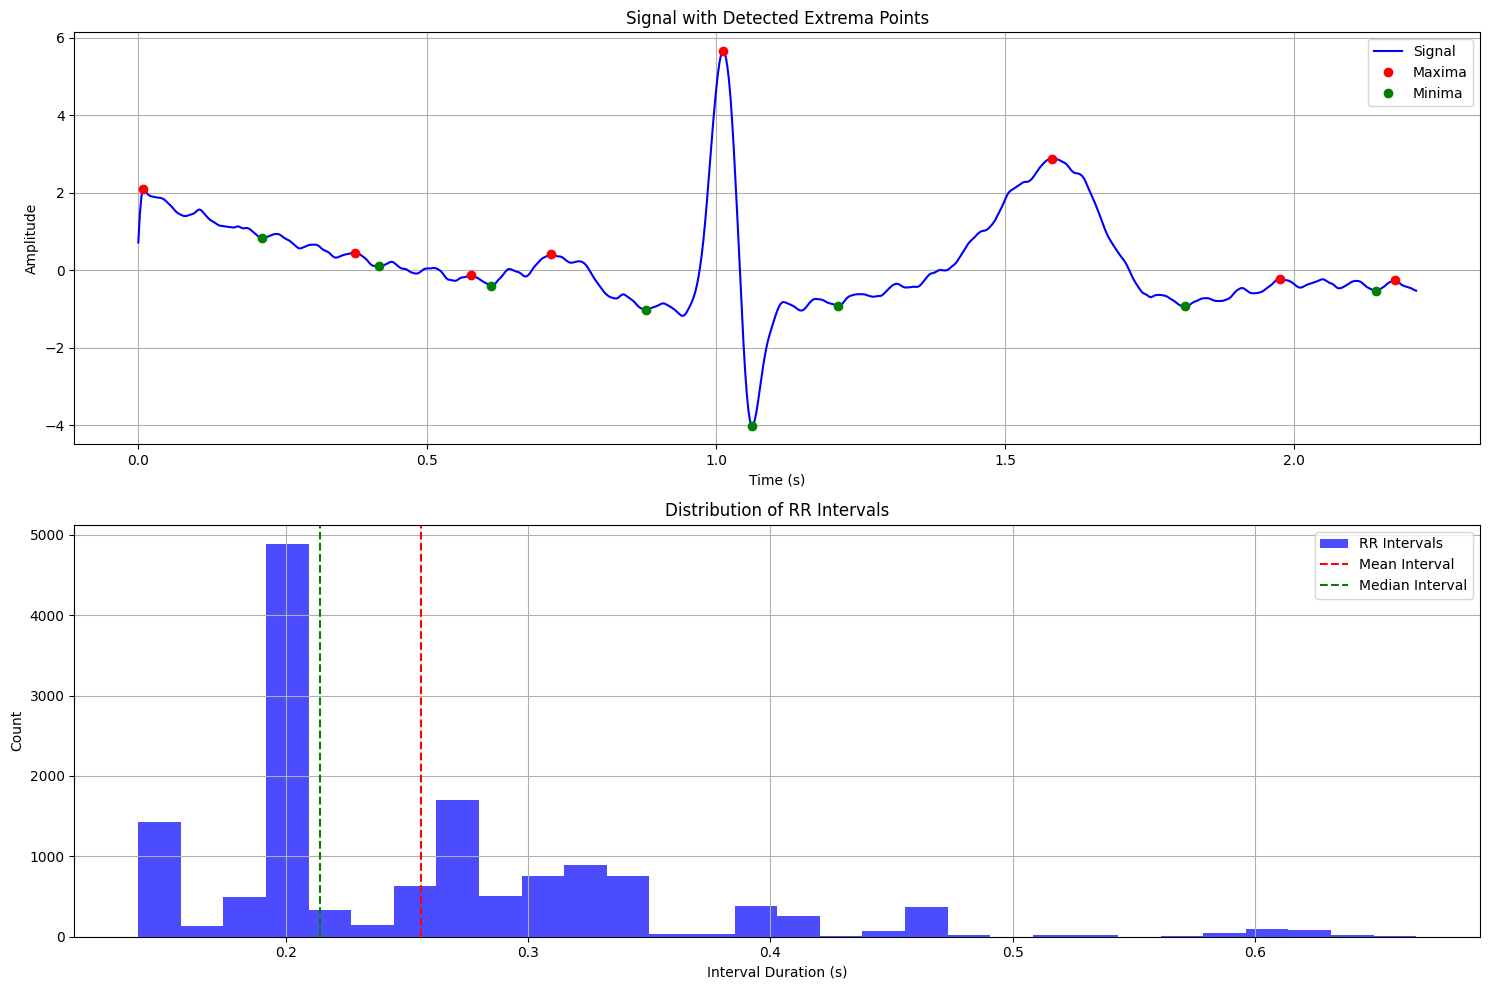


Analyzing characteristics for record: 119

Interval Statistics:
RR Intervals: Mean = 0.235s, Std = 0.076s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.644
Max Amplitude (mean ± std): 0.813 ± 1.741


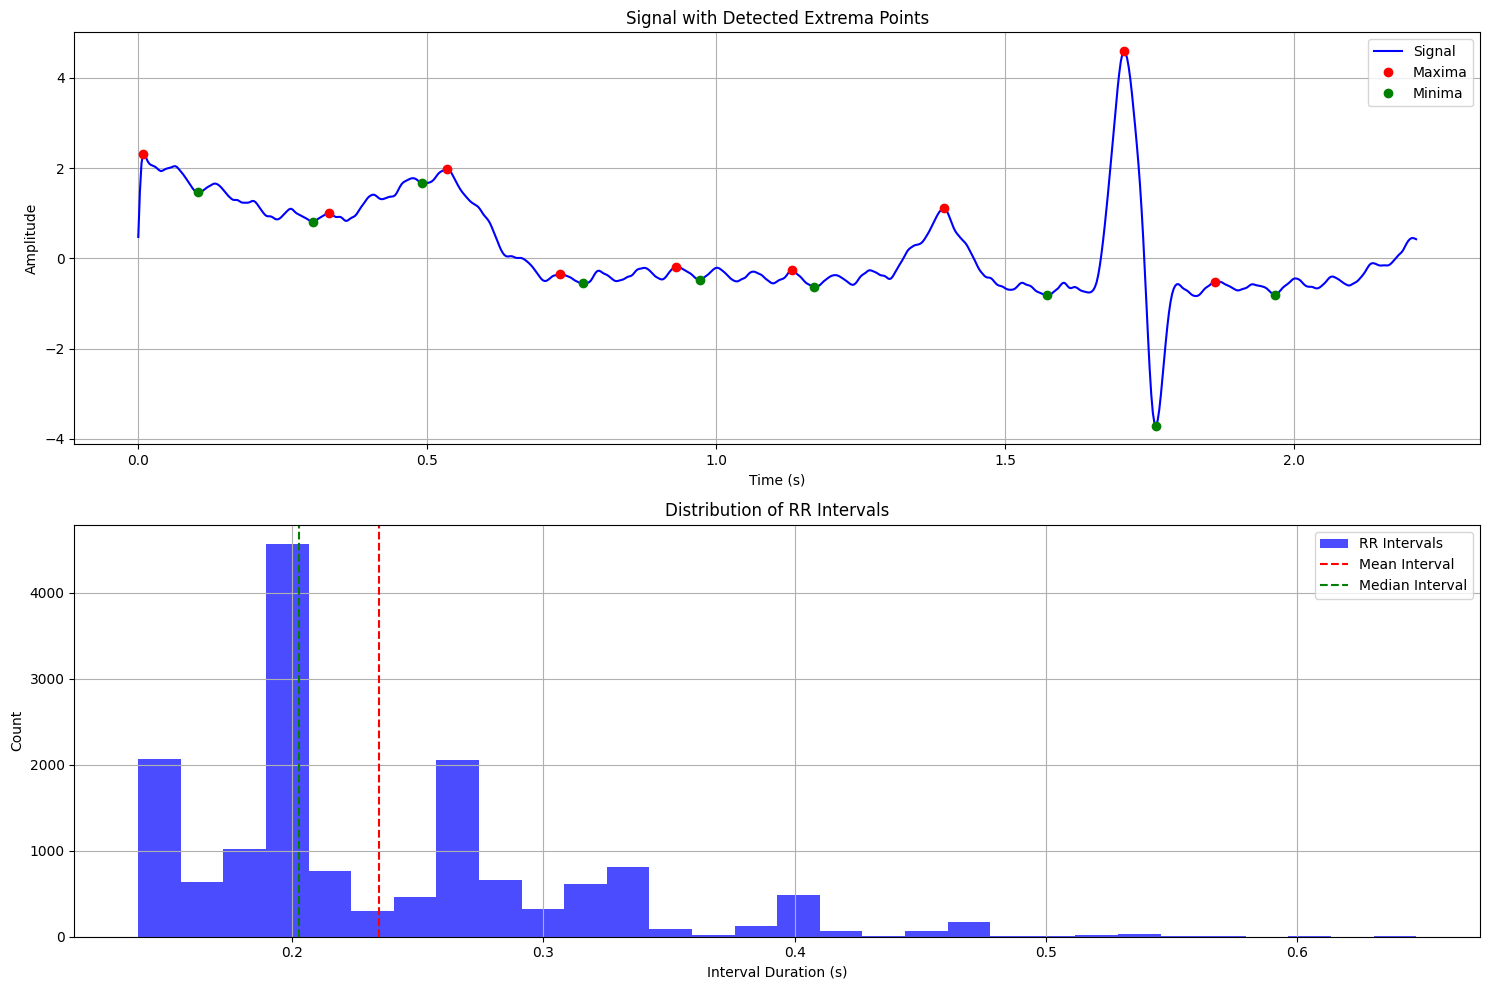


Analyzing characteristics for record: 122

Interval Statistics:
RR Intervals: Mean = 0.215s, Std = 0.063s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.258
Max Amplitude (mean ± std): 0.690 ± 1.694


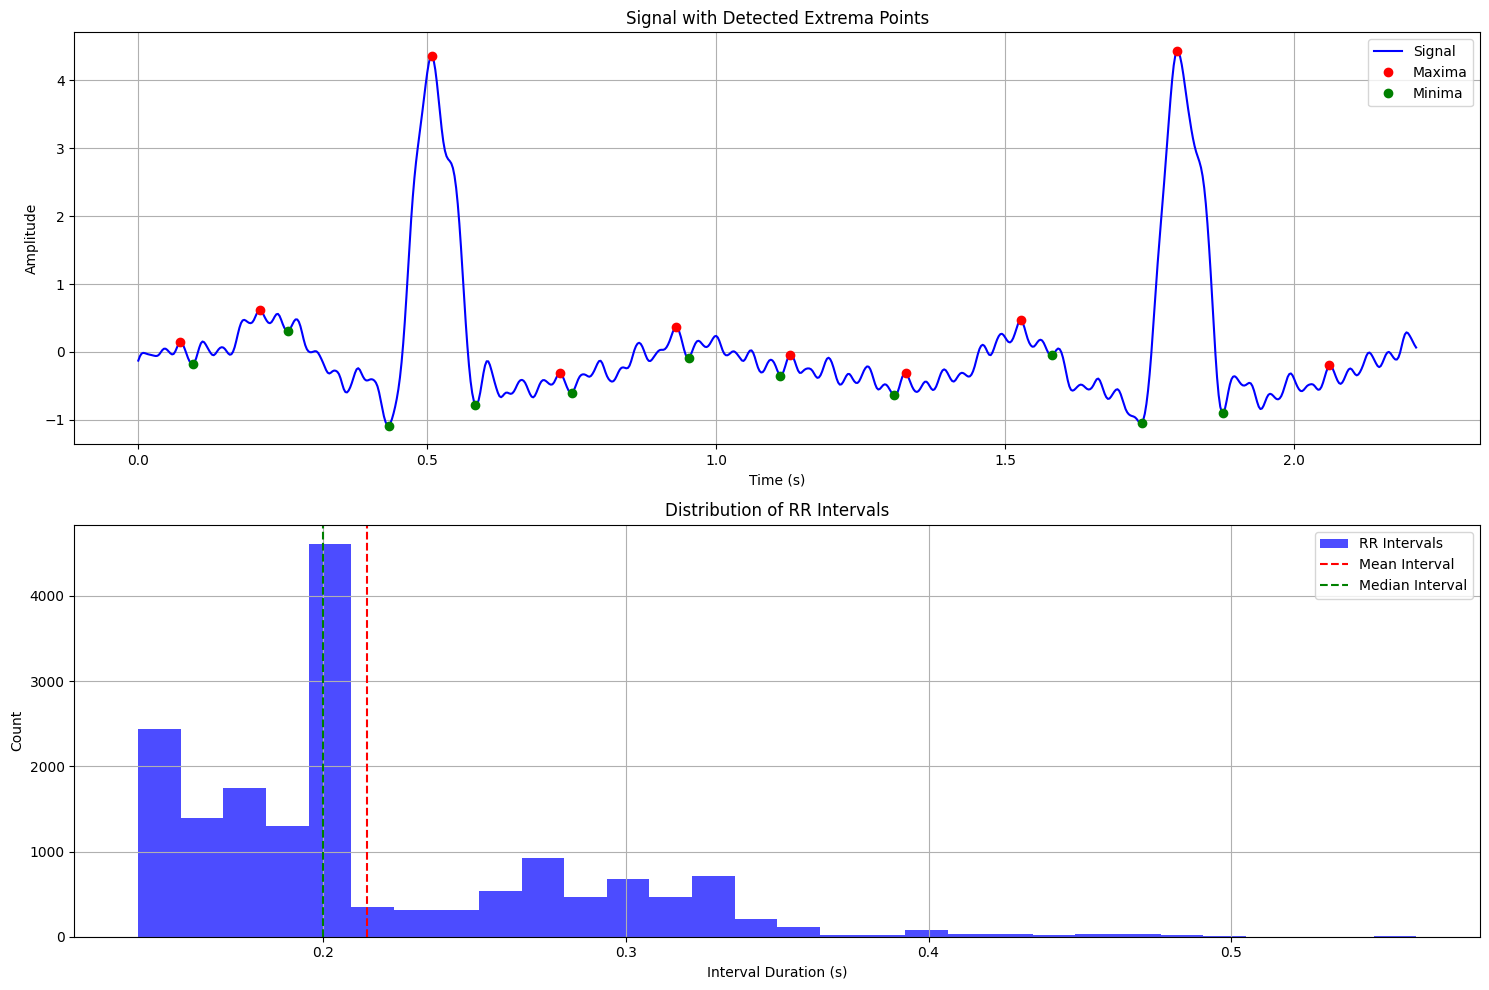


Analyzing characteristics for record: 207

Interval Statistics:
RR Intervals: Mean = 0.296s, Std = 0.154s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.203
Max Amplitude (mean ± std): 0.469 ± 0.774


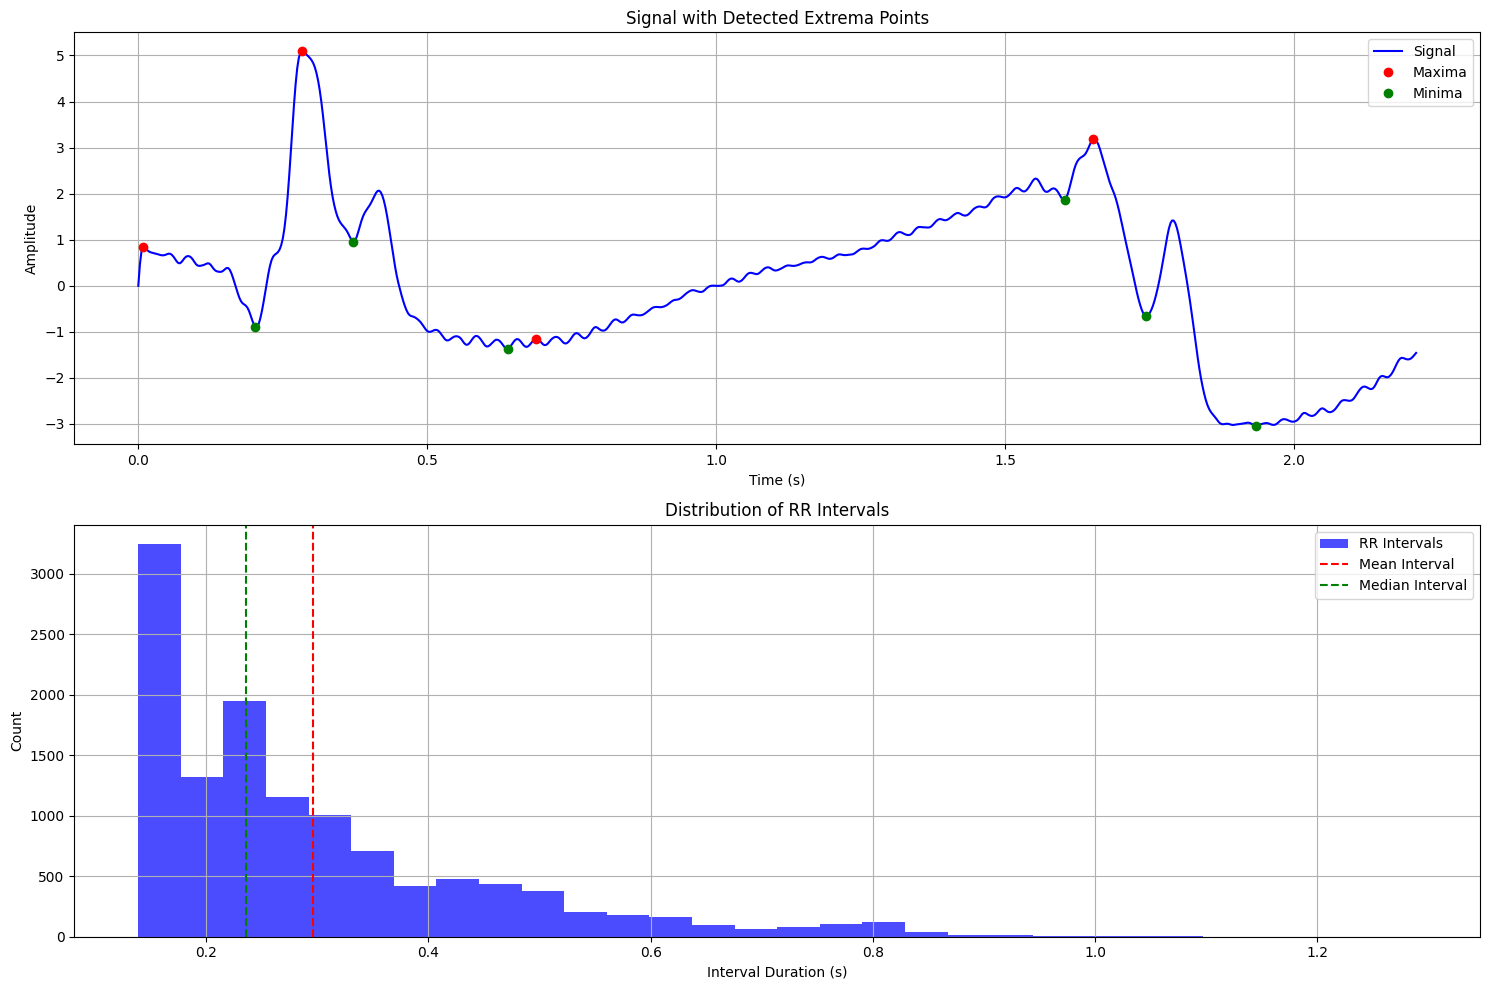


Analyzing characteristics for record: 214

Interval Statistics:
RR Intervals: Mean = 0.210s, Std = 0.067s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.276
Max Amplitude (mean ± std): 0.708 ± 1.651


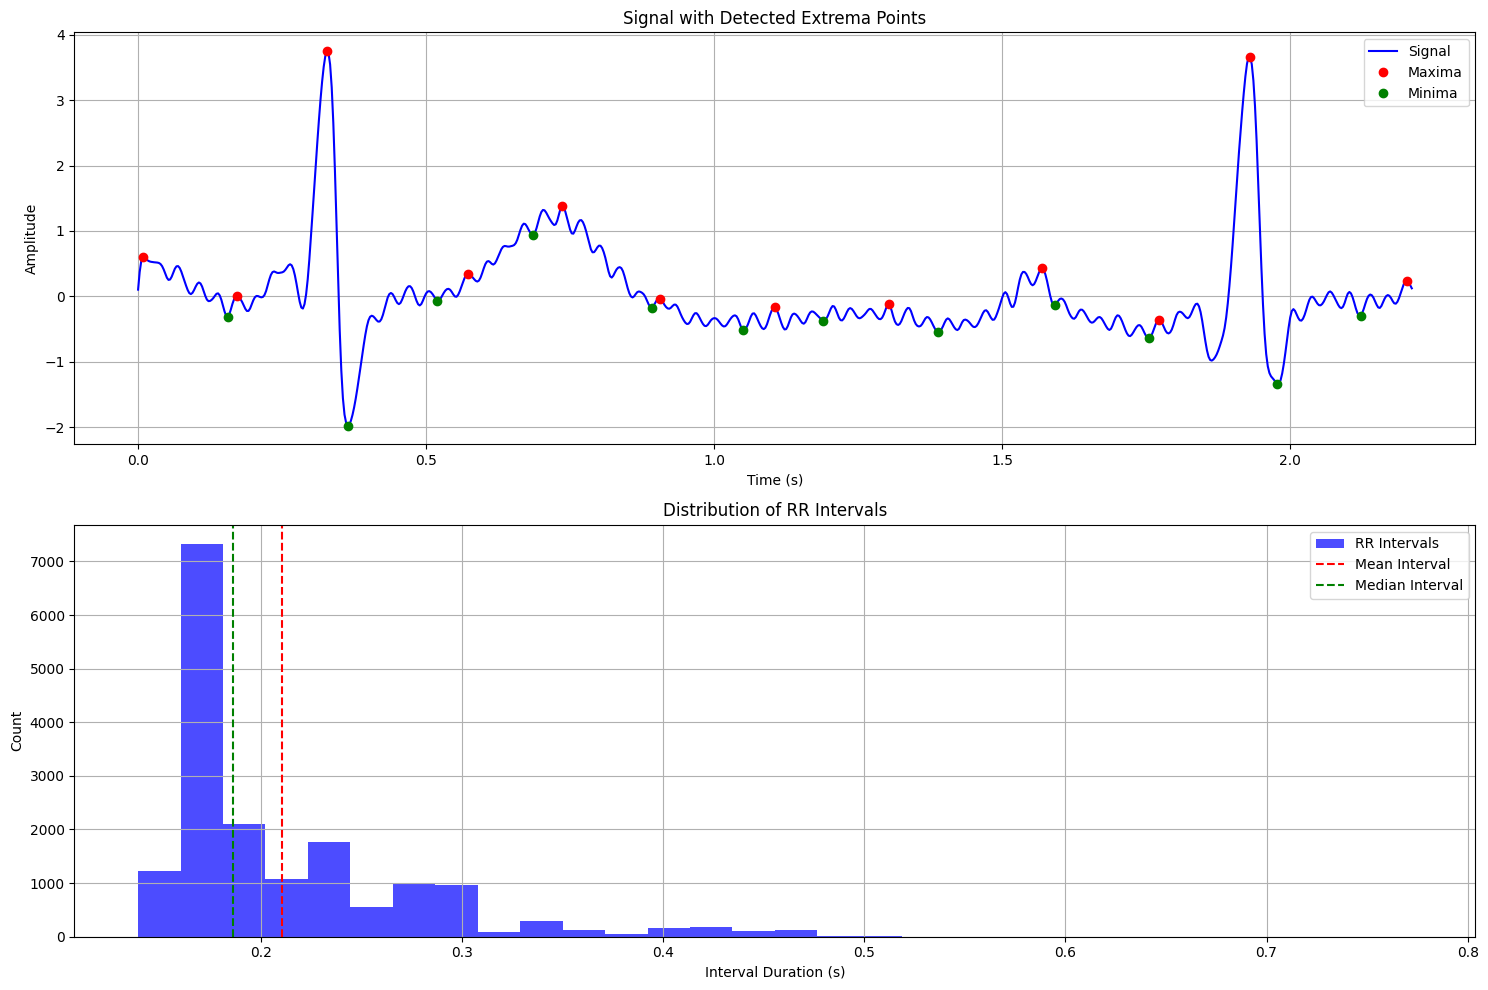


Analyzing characteristics for record: 222

Interval Statistics:
RR Intervals: Mean = 0.203s, Std = 0.049s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.781
Max Amplitude (mean ± std): 0.760 ± 0.966


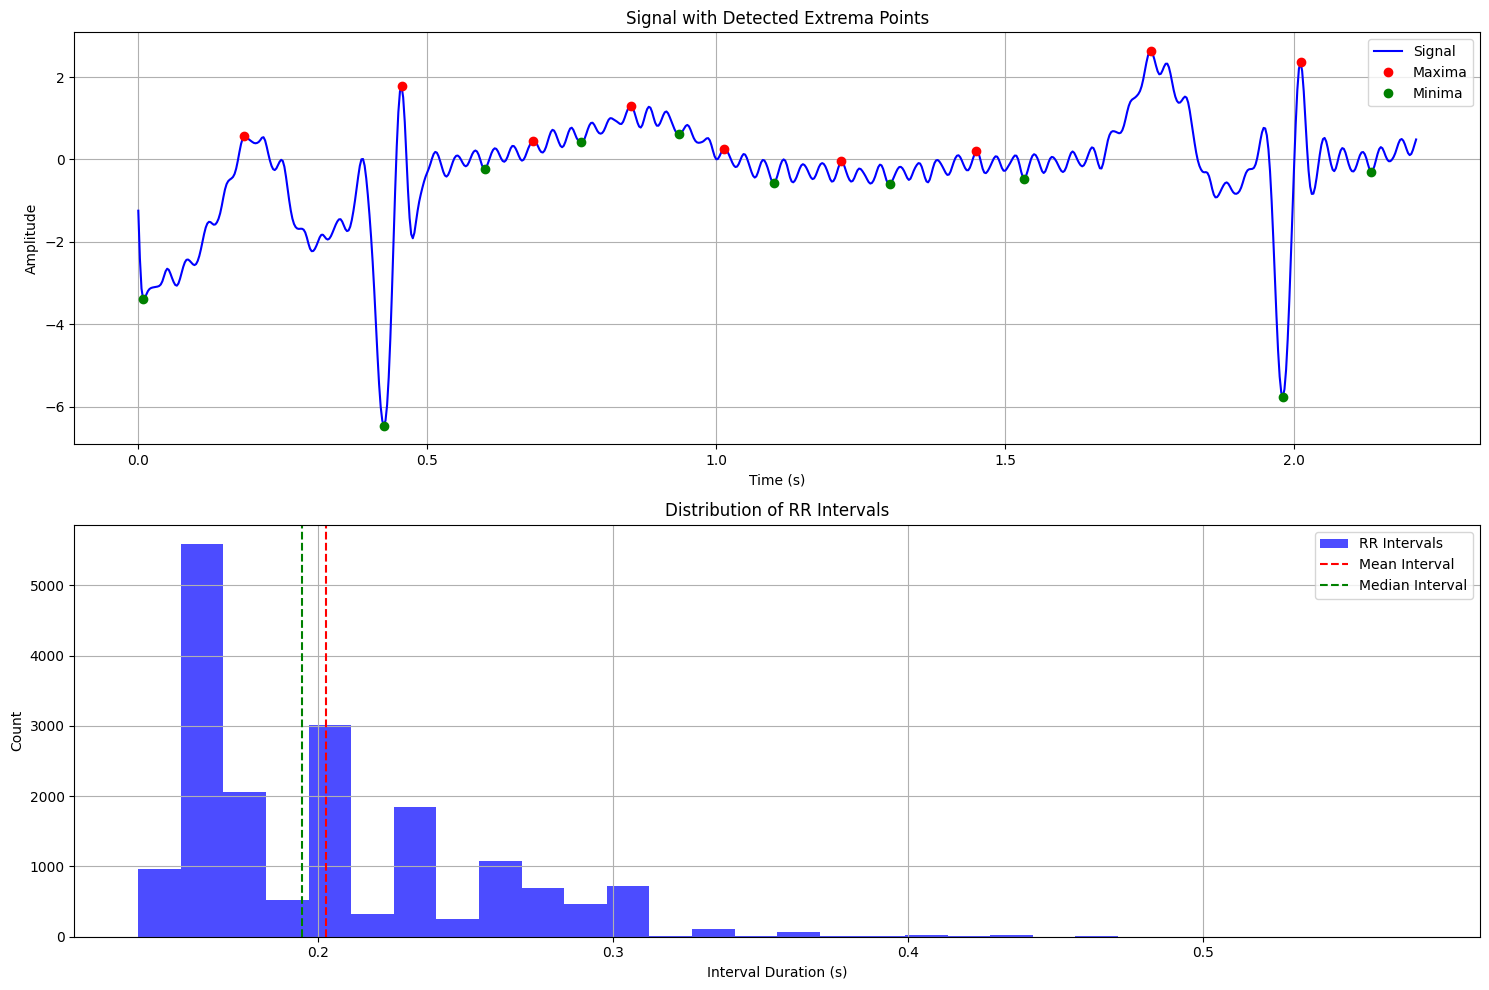


Analyzing characteristics for record: 223

Interval Statistics:
RR Intervals: Mean = 0.261s, Std = 0.105s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.647
Max Amplitude (mean ± std): 0.771 ± 1.456


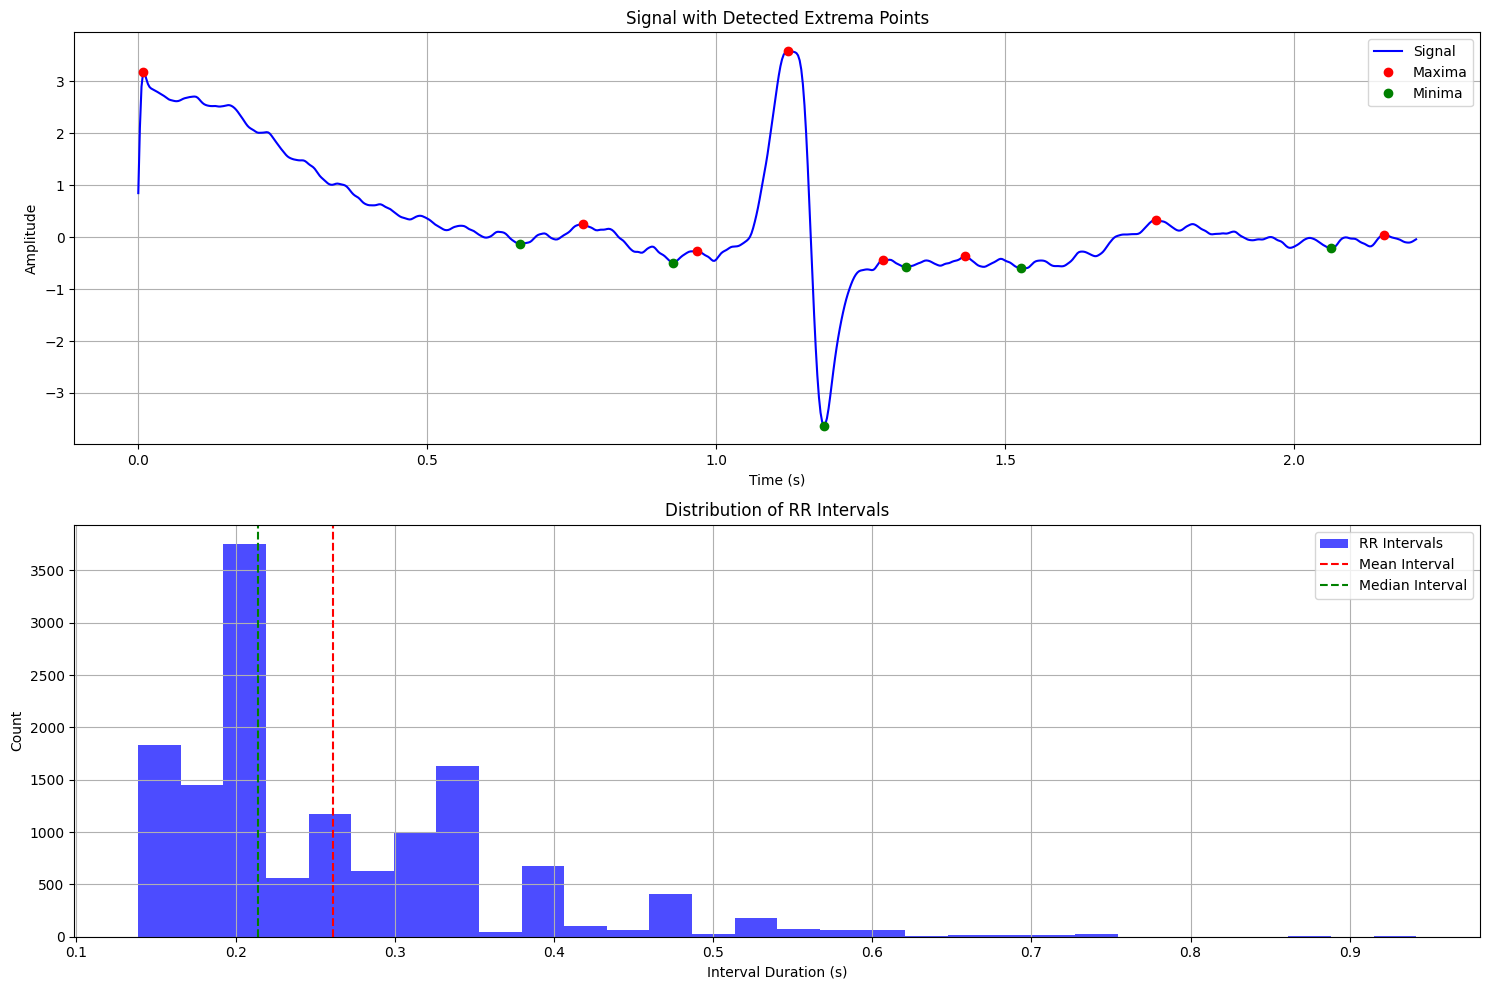


Analyzing characteristics for record: 231

Interval Statistics:
RR Intervals: Mean = 0.223s, Std = 0.072s

Amplitude Statistics:
Peak-to-Peak Amplitude: 1.460
Max Amplitude (mean ± std): 0.899 ± 2.448


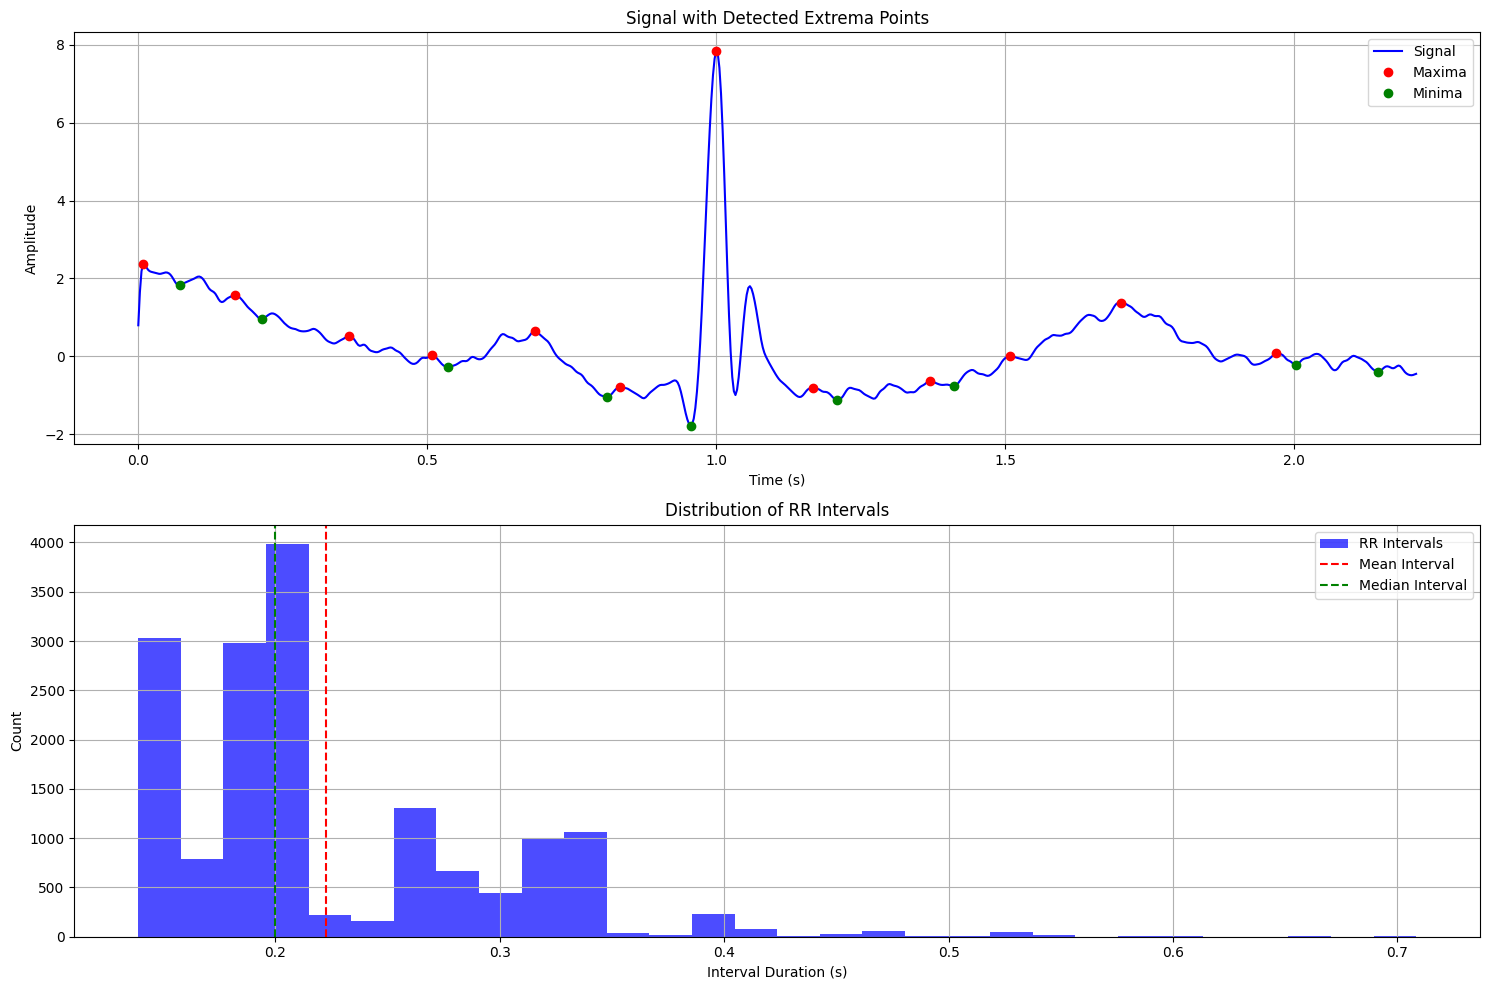

In [96]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy import stats
# Initialize ECG characteristics analyzer.
class ECGCharacteristics:
    def __init__(self, fs=360):
        
        self.fs = fs
       # Finding local maxima and minima in the signal with their characteristics. 
    def find_local_extrema(self, signal, distance=50, prominence=0.1):
        
        # Finding maxima
        maxima_idx, maxima_props = find_peaks(
            signal,
            distance=distance,
            prominence=prominence
        )
        
        # Finding minima by inverting the signal
        minima_idx, minima_props = find_peaks(
            -signal,
            distance=distance,
            prominence=prominence
        )
        
        return {
            'maxima': {
                'indices': maxima_idx,
                'values': signal[maxima_idx],
                'prominences': maxima_props['prominences'],
                'widths': maxima_props.get('widths', np.zeros_like(maxima_idx))
            },
            'minima': {
                'indices': minima_idx,
                'values': signal[minima_idx],
                'prominences': minima_props['prominences'],
                'widths': minima_props.get('widths', np.zeros_like(minima_idx))
            }
        }
    # Calculating intervals between successive extrema points.
    def calculate_intervals(self, extrema_info):
       
       
        rr_intervals = np.diff(extrema_info['maxima']['indices']) / self.fs
        
       
        mm_intervals = np.diff(extrema_info['minima']['indices']) / self.fs
        
        
        interval_stats = {
            'RR_intervals': {
                'mean': np.mean(rr_intervals),
                'std': np.std(rr_intervals),
                'median': np.median(rr_intervals),
                'iqr': stats.iqr(rr_intervals),
                'raw_values': rr_intervals
            },
            'MM_intervals': {
                'mean': np.mean(mm_intervals),
                'std': np.std(mm_intervals),
                'median': np.median(mm_intervals),
                'iqr': stats.iqr(mm_intervals),
                'raw_values': mm_intervals
            }
        }
        
        return interval_stats
    # Calculating amplitude characteristics of the signal. 
    def calculate_amplitudes(self, extrema_info):
       
        max_amplitudes = extrema_info['maxima']['values']
        min_amplitudes = extrema_info['minima']['values']
        
       
        p2p_amplitudes = np.abs(np.mean(max_amplitudes) - np.mean(min_amplitudes))
        
        amplitude_stats = {
            'maxima': {
                'mean': np.mean(max_amplitudes),
                'std': np.std(max_amplitudes),
                'median': np.median(max_amplitudes),
                'iqr': stats.iqr(max_amplitudes)
            },
            'minima': {
                'mean': np.mean(min_amplitudes),
                'std': np.std(min_amplitudes),
                'median': np.median(min_amplitudes),
                'iqr': stats.iqr(min_amplitudes)
            },
            'peak_to_peak': p2p_amplitudes
        }
        
        return amplitude_stats
    # Plot signal with marked characteristics.
    def plot_characteristics(self, signal, extrema_info, window_size=797):
       
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        
        time = np.arange(window_size) / self.fs
        
        
        ax1.plot(time, signal[:window_size], 'b-', label='Signal')
        ax1.plot(extrema_info['maxima']['indices'][extrema_info['maxima']['indices'] < window_size] / self.fs,
                extrema_info['maxima']['values'][extrema_info['maxima']['indices'] < window_size],
                'ro', label='Maxima')
        ax1.plot(extrema_info['minima']['indices'][extrema_info['minima']['indices'] < window_size] / self.fs,
                extrema_info['minima']['values'][extrema_info['minima']['indices'] < window_size],
                'go', label='Minima')
        
        ax1.set_title('Signal with Detected Extrema Points')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True)
        ax1.legend()
        
       
        intervals = np.diff(extrema_info['maxima']['indices']) / self.fs
        ax2.hist(intervals, bins=30, alpha=0.7, color='blue', label='RR Intervals')
        ax2.axvline(np.mean(intervals), color='r', linestyle='--', label='Mean Interval')
        ax2.axvline(np.median(intervals), color='g', linestyle='--', label='Median Interval')
        
        ax2.set_title('Distribution of RR Intervals')
        ax2.set_xlabel('Interval Duration (s)')
        ax2.set_ylabel('Count')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        return fig


analyzer = ECGCharacteristics(fs=360)

for idx, record_name in enumerate(file_names):  
    print(f"\nAnalyzing characteristics for record: {record_name}")
    
    signal = processed_signals[idx]['scaled']
    
    
    extrema_info = analyzer.find_local_extrema(signal)
    
    # Calculating intervals and amplitudes
    intervals = analyzer.calculate_intervals(extrema_info)
    amplitudes = analyzer.calculate_amplitudes(extrema_info)
    
   
    print("\nInterval Statistics:")
    print(f"RR Intervals: Mean = {intervals['RR_intervals']['mean']:.3f}s, "
          f"Std = {intervals['RR_intervals']['std']:.3f}s")
    
    print("\nAmplitude Statistics:")
    print(f"Peak-to-Peak Amplitude: {amplitudes['peak_to_peak']:.3f}")
    print(f"Max Amplitude (mean ± std): {amplitudes['maxima']['mean']:.3f} ± "
          f"{amplitudes['maxima']['std']:.3f}")
    
    
    fig = analyzer.plot_characteristics(signal, extrema_info)
    plt.show()

Extracting features for all signals...
Extracting features...
Processed 10/12 signals
Feature extraction completed!
           mean  std  skewness   kurtosis  rms   rr_mean    rr_std  rr_ratio  \
0  8.449993e-18  1.0  4.847989  29.774128  1.0  0.261933  0.102690      5.28   
1 -6.367556e-18  1.0  4.759590  28.476363  1.0  0.224251  0.079909      4.88   
2  7.993606e-18  1.0  3.094536  17.463435  1.0  0.400462  0.116561      9.14   
3 -4.110216e-18  1.0  2.334093  15.222323  1.0  0.245132  0.096285      6.66   
4 -5.870176e-18  1.0  2.035554   8.569917  1.0  0.255824  0.092333      4.80   

    rr_pnn50  peak_to_peak  peak_amplitude_mean  peak_amplitude_std  \
0  64.678999     26.165330             1.233167            2.605211   
1  53.440994     15.577545             0.941935            2.403072   
2  79.913487     17.738517             1.674374            2.448331   
3  56.782077     18.520535             0.846848            1.789099   
4  64.458301     12.266346             0.790916 

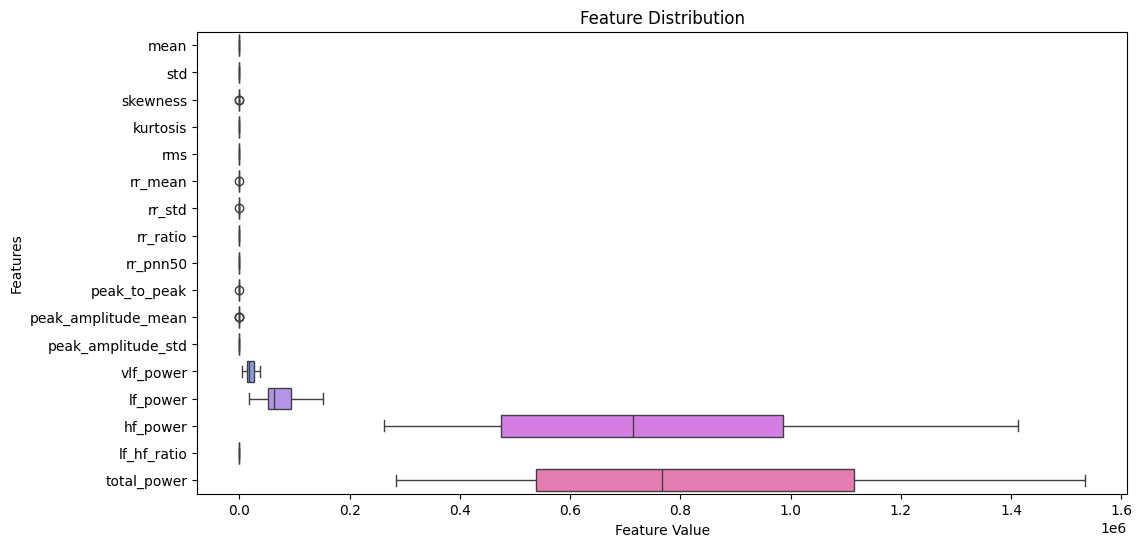

In [97]:

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm

#  Feature Extraction Class
class ECGFeatureExtractor:
    def __init__(self, fs=360):
        self.fs = fs
        
    def extract_time_domain_features(self, signal, extrema_info):
       
        
        stats_features = {
            'mean': np.mean(signal),
            'std': np.std(signal),
            'skewness': stats.skew(signal),
            'kurtosis': stats.kurtosis(signal),
            'rms': np.sqrt(np.mean(np.square(signal)))
        }
        
      
        rr_intervals = np.diff(extrema_info['maxima']['indices']) / self.fs
        interval_features = {
            'rr_mean': np.mean(rr_intervals),
            'rr_std': np.std(rr_intervals),
            'rr_ratio': np.max(rr_intervals) / np.min(rr_intervals) if len(rr_intervals) > 0 else 0,
            'rr_pnn50': self._calculate_pnn50(rr_intervals)
        }
        
       
        amp_features = {
            'peak_to_peak': np.max(signal) - np.min(signal),
            'peak_amplitude_mean': np.mean(extrema_info['maxima']['values']),
            'peak_amplitude_std': np.std(extrema_info['maxima']['values'])
        }
        
        return {**stats_features, **interval_features, **amp_features}
    
    def extract_frequency_domain_features(self, signal):
        
        
        fft_vals = np.abs(np.fft.rfft(signal))
        fft_freqs = np.fft.rfftfreq(len(signal), 1/self.fs)
        
        
        vlf_range = (0, 0.04)
        lf_range = (0.04, 0.15)
        hf_range = (0.15, 0.4)
        
       
        vlf_power = np.sum(fft_vals[(fft_freqs >= vlf_range[0]) & (fft_freqs < vlf_range[1])])
        lf_power = np.sum(fft_vals[(fft_freqs >= lf_range[0]) & (fft_freqs < lf_range[1])])
        hf_power = np.sum(fft_vals[(fft_freqs >= hf_range[0]) & (fft_freqs < hf_range[1])])
        total_power = vlf_power + lf_power + hf_power
        
        return {
            'vlf_power': vlf_power,
            'lf_power': lf_power,
            'hf_power': hf_power,
            'lf_hf_ratio': lf_power / hf_power if hf_power != 0 else 0,
            'total_power': total_power
        }
    
    def _calculate_pnn50(self, rr_intervals):
        
        if len(rr_intervals) < 2:
            return 0
        differences = np.abs(np.diff(rr_intervals))
        nn50 = np.sum(differences > 0.05)  # 50 ms = 0.05 s
        return (nn50 / len(differences)) * 100 if len(differences) > 0 else 0


def extract_all_features(signals, processed_signals, annotations):
   
    extractor = ECGFeatureExtractor()
    all_features = []
    
    print("Extracting features...")
    for i in range(len(signals)):
        
        raw_signal = signals[i]
        proc_signal = processed_signals[i]['scaled']
        
        # Finding extrema points using the previously defined function from ECGCharacteristics
        extrema_info = analyzer.find_local_extrema(proc_signal)
        
       
        time_features = extractor.extract_time_domain_features(proc_signal, extrema_info)
        freq_features = extractor.extract_frequency_domain_features(proc_signal)
        
        
        features = {**time_features, **freq_features}
        all_features.append(features)
        
       
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(signals)} signals")
    
    print("Feature extraction completed!")
    return pd.DataFrame(all_features)



# Data Preparation and Feature Selection
print("Extracting features for all signals...")
X = extract_all_features(signals, processed_signals, annotations)
print(X.head())

print(f"Extracted features shape: {X.shape}")

def plot_feature_distribution(df):
    """Plot the distribution of the features."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, orient='h')
    plt.title("Feature Distribution")
    plt.xlabel("Feature Value")
    plt.ylabel("Features")
    plt.show()

plot_feature_distribution(X)


rr_std_values = X['rr_std'].copy()  


y = (rr_std_values > rr_std_values.median()).astype(int)


X = X.drop('rr_std', axis=1)




In [98]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE





print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
print("\nPerforming feature selection...")
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Selected feature names
selected_features = np.array(X_train.columns)[selector.get_support()]  # Modify as per your data type
print("\nSelected features:", selected_features)


smote = SMOTE(random_state=42, k_neighbors=3)
X_train_selected, y_train = smote.fit_resample(X_train_selected, y_train)

def calculate_metrics_from_clusters(y_true, y_pred):
    
    labels = np.zeros_like(y_pred)
    
    for i in range(np.max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y_true[mask])[0]
    
    accuracy = accuracy_score(y_true, labels)
    precision = precision_score(y_true, labels, zero_division=1)
    recall = recall_score(y_true, labels, zero_division=1)
    
    return accuracy, precision, recall

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    
    models = {
        # Supervised models
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'linear', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Neural Network': {
            'model': MLPClassifier(random_state=42, max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01]
            }
        },
        # Unsupervised models
        'GMM': {
            'model': GaussianMixture(random_state=42),
            'params': {
                'n_components': [2, 4, 6, 8],
                'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                'reg_covar': [1e-2, 1e-3, 1e-4]  # Regularization to handle covariance issues
            }
        }
    }
    
    results = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'GMM':
            # For unsupervised GMM
            grid_search = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1)
            grid_search.fit(X_train)
            y_pred_test = grid_search.predict(X_test)
            acc, prec, rec = calculate_metrics_from_clusters(y_test, y_pred_test)

            results[name] = {
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'best_params': grid_search.best_params_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")
        
        else:
            # For supervised models 
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', config['model'])
            ])

            pipeline_params = {'model__' + key: value for key, value in config['params'].items()}

            grid_search = RandomizedSearchCV(pipeline, pipeline_params, cv=5, n_jobs=-1, n_iter=50, random_state=42)
            grid_search.fit(X_train, y_train)

            y_pred = grid_search.predict(X_test)

            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=1),
                'recall': recall_score(y_test, y_pred, zero_division=1),
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {results[name]['accuracy']:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")

    return results


print("\nTraining and evaluating models...")
model_results = train_and_evaluate_models(X_train_selected, X_test_selected, y_train, y_test)


print("\nSummary of Model Performance:\n")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10}")

for model_name, result in model_results.items():
    print(f"{model_name:<20} {result['accuracy']:<10.3f} {result['precision']:<10.3f} {result['recall']:<10.3f}")


Splitting data into train and test sets...

Performing feature selection...

Selected features: ['mean' 'std' 'skewness' 'kurtosis' 'rms' 'rr_mean' 'rr_ratio' 'rr_pnn50'
 'peak_amplitude_std' 'hf_power']

Training and evaluating models...

Training RandomForest...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForest Results:
Accuracy: 1.000
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__max_depth': 10}

Training SVM...
SVM Results:
Accuracy: 1.000
Best parameters: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__C': 1}

Training Neural Network...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Neural Network Results:
Accuracy: 0.667
Best parameters: {'model__hidden_layer_sizes': (100, 50), 'model__alpha': 0.0001, 'model__activation': 'relu'}

Training GMM...
GMM Results:
Accuracy: 0.667, Precision: 1.000, Recall: 0.500
Best parameters: {'covariance_type': 'diag', 'n_components': 2, 'reg_covar': 0.0001}

Summary of Model Performance:

Model                Accuracy   Precision  Recall    
RandomForest         1.000      1.000      1.000     
SVM                  1.000      1.000      1.000     
Neural Network       0.667      1.000      0.500     
GMM                  0.667      1.000      0.500     


In [103]:
# First store the peak_to_peak values 
peak_values = X['peak_to_peak'].copy()  


y = (peak_values > peak_values.median()).astype(int)


X = X.drop('peak_to_peak', axis=1)

In [104]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from scipy.stats import mode




print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Feature selection
print("\nPerforming feature selection...")
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


selected_features = np.array(X_train.columns)[selector.get_support()]  
print("\nSelected features:", selected_features)


smote = SMOTE(random_state=42, k_neighbors=3)
X_train_selected, y_train = smote.fit_resample(X_train_selected, y_train)

def calculate_metrics_from_clusters(y_true, y_pred):
    
    labels = np.zeros_like(y_pred)
    
    for i in range(np.max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y_true[mask])[0]
    
    accuracy = accuracy_score(y_true, labels)
    precision = precision_score(y_true, labels, zero_division=1)
    recall = recall_score(y_true, labels, zero_division=1)
    
    return accuracy, precision, recall

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models."""
    models = {
        # Supervised models
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced', None]
            }
        },
        'Neural Network': {
            'model': MLPClassifier(random_state=42, max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.001, 0.01]
            }
        },
        # Unsupervised models
        'GMM': {
            'model': GaussianMixture(random_state=42),
            'params': {
                'n_components': [2, 4, 6, 8],
                'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                'reg_covar': [1e-2, 1e-3, 1e-4]  # Regularization to handle covariance issues
            }
        }
    }
    
    results = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'GMM':
            # For unsupervised GMM
            grid_search = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1)
            grid_search.fit(X_train)
            y_pred_test = grid_search.predict(X_test)
            acc, prec, rec = calculate_metrics_from_clusters(y_test, y_pred_test)

            results[name] = {
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'best_params': grid_search.best_params_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")
        
        else:
            # For supervised models 
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', config['model'])
            ])

            pipeline_params = {'model__' + key: value for key, value in config['params'].items()}

            grid_search = RandomizedSearchCV(pipeline, pipeline_params, cv=5, n_jobs=-1, n_iter=50, random_state=42)
            grid_search.fit(X_train_selected, y_train)

            y_pred = grid_search.predict(X_test_selected)

            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {results[name]['accuracy']:.3f}")
            print(f"Precision: {results[name]['precision']:.3f}")
            print(f"Recall: {results[name]['recall']:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")

    return results


print("\nTraining and evaluating models...")
model_results = train_and_evaluate_models(X_train_selected, X_test_selected, y_train, y_test)


print("\nSummary of Model Performance:\n")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10}")

for model_name, result in model_results.items():
    print(f"{model_name:<20} {result['accuracy']:<10.3f} {result['precision']:<10.3f} {result['recall']:<10.3f}")


Splitting data into train and test sets...

Performing feature selection...

Selected features: ['std' 'kurtosis' 'rms' 'rr_mean' 'rr_ratio' 'rr_pnn50' 'vlf_power'
 'lf_power' 'lf_hf_ratio' 'total_power']

Training and evaluating models...

Training RandomForest...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


RandomForest Results:
Accuracy: 0.333
Precision: 0.500
Recall: 0.500
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 30, 'model__bootstrap': False}

Training SVM...
SVM Results:
Accuracy: 0.333
Precision: 0.500
Recall: 0.500
Best parameters: {'model__kernel': 'sigmoid', 'model__gamma': 'auto', 'model__class_weight': 'balanced', 'model__C': 0.1}

Training Neural Network...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Neural Network Results:
Accuracy: 0.333
Precision: 0.500
Recall: 0.500
Best parameters: {'model__learning_rate_init': 0.001, 'model__hidden_layer_sizes': (50,), 'model__alpha': 0.0001, 'model__activation': 'relu'}

Training GMM...
GMM Results:
Accuracy: 0.667, Precision: 1.000, Recall: 0.500
Best parameters: {'covariance_type': 'diag', 'n_components': 2, 'reg_covar': 0.0001}

Summary of Model Performance:

Model                Accuracy   Precision  Recall    
RandomForest         0.333      0.500      0.500     
SVM                  0.333      0.500      0.500     
Neural Network       0.333      0.500      0.500     
GMM                  0.667      1.000      0.500     


In [101]:
# First store the  values hf_power
hf = X['hf_power'].copy()  

y = (hf > hf.median()).astype(int)


X = X.drop('hf_power', axis=1)

In [102]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from scipy.stats import mode

print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
print("\nPerforming feature selection...")
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Selected feature names
selected_features = np.array(X_train.columns)[selector.get_support()]  
print("\nSelected features:", selected_features)


smote = SMOTE(random_state=42, k_neighbors=3)
X_train_selected, y_train = smote.fit_resample(X_train_selected, y_train)

def calculate_metrics_from_clusters(y_true, y_pred):
    
    labels = np.zeros_like(y_pred)
    
    for i in range(np.max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y_true[mask])[0]
    
    accuracy = accuracy_score(y_true, labels)
    precision = precision_score(y_true, labels, zero_division=1)
    recall = recall_score(y_true, labels, zero_division=1)
    
    return accuracy, precision, recall

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    
    models = {
        # Supervised models
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced', None]
            }
        },
        'Neural Network': {
            'model': MLPClassifier(random_state=42, max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.001, 0.01]
            }
        },
        # Unsupervised models
        'GMM': {
            'model': GaussianMixture(random_state=42),
            'params': {
                'n_components': [2, 4, 6, 8],
                'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                'reg_covar': [1e-2, 1e-3, 1e-4]  # Regularization to handle covariance issues
            }
        }
    }
    
    results = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'GMM':
            # For unsupervised GMM
            grid_search = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1)
            grid_search.fit(X_train)
            y_pred_test = grid_search.predict(X_test)
            acc, prec, rec = calculate_metrics_from_clusters(y_test, y_pred_test)

            results[name] = {
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'best_params': grid_search.best_params_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")
        
        else:
            # For supervised models 
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', config['model'])
            ])

            pipeline_params = {'model__' + key: value for key, value in config['params'].items()}

            grid_search = RandomizedSearchCV(pipeline, pipeline_params, cv=5, n_jobs=-1, n_iter=50, random_state=42)
            grid_search.fit(X_train_selected, y_train)

            y_pred = grid_search.predict(X_test_selected)

            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }

            print(f"{name} Results:")
            print(f"Accuracy: {results[name]['accuracy']:.3f}")
            print(f"Precision: {results[name]['precision']:.3f}")
            print(f"Recall: {results[name]['recall']:.3f}")
            print(f"Best parameters: {results[name]['best_params']}")

    return results


print("\nTraining and evaluating models...")
model_results = train_and_evaluate_models(X_train_selected, X_test_selected, y_train, y_test)


print("\nSummary of Model Performance:\n")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10}")

for model_name, result in model_results.items():
    print(f"{model_name:<20} {result['accuracy']:<10.3f} {result['precision']:<10.3f} {result['recall']:<10.3f}")


Splitting data into train and test sets...

Performing feature selection...

Selected features: ['mean' 'skewness' 'kurtosis' 'rr_mean' 'rr_ratio' 'rr_pnn50'
 'peak_amplitude_std' 'vlf_power' 'lf_power' 'total_power']

Training and evaluating models...

Training RandomForest...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [1 4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


RandomForest Results:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 30, 'model__bootstrap': False}

Training SVM...
SVM Results:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
Best parameters: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__class_weight': 'balanced', 'model__C': 0.1}

Training Neural Network...


C:\Users\jalad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Neural Network Results:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
Best parameters: {'model__learning_rate_init': 0.001, 'model__hidden_layer_sizes': (50,), 'model__alpha': 0.0001, 'model__activation': 'relu'}

Training GMM...
GMM Results:
Accuracy: 1.000, Precision: 1.000, Recall: 1.000
Best parameters: {'covariance_type': 'diag', 'n_components': 2, 'reg_covar': 0.0001}

Summary of Model Performance:

Model                Accuracy   Precision  Recall    
RandomForest         1.000      1.000      1.000     
SVM                  1.000      1.000      1.000     
Neural Network       1.000      1.000      1.000     
GMM                  1.000      1.000      1.000     


In [ ]:
# code reference 
# https://medium.com/@protobioengineering/how-to-get-heart-data-from-the-mit-bih-arrhythmia-database-e452d4bf7215

